# Predicting Exoplanets vs False Positives in TESS Observations


# Introduction

This project was developed for Python 3.13.1 and the following libraries must be installed:
- scikit-learn
- numpy
- pandas
- seaborn
- matplotlib
- xgboost (installed by running the notebook)

## Project Summary
This project looks to compare the performance of four different machine learning models in predicting the planetary status of potential exoplanet
observations recorded in the TESS Project Candidates table. If the difference between classes can effecitvley be learned, the TESS follow-up observation program working group (TFOPWG) could use the best performing model
to assist with vetting unclassified candidates by prioritizing those most likely to be exoplanets.

The dataset can be downloaded from [TESS Project Candidates Table](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=TOI)


## Background

Astronomers believe that exoplanets are highly abundant in our universe, as more planets are being discovered each year. 
TESS, the Transiting Exoplanet Survey Satellite, test this hypothesis by surveying around 200,000 nearby stars across the entire sky with its four wide-field cameras. TESS
detects exoplanets when they transit their host star, causing a measurable dip in brightness that be used to predict the characteristics
of both the exoplanet and its star when combined with data collected from other telescopes and missions [[1]](https://www.cfa.harvard.edu/facilities-technology/telescopes-instruments/transiting-exoplanet-survey-satellite-tess).

## Motivation
As of April 2nd, 2025, TESS has discovered 620 confirmed exoplanets, with over 4,800 other candidates still awaiting classification. Candidates must be sufficiently vetted
by researchers in order to be confirmed as either a planet or false positive. The time it takes for candidates to be classified is determined by the availability of follow-up resources
and observation windows 

**Sources:**</br>
[1] https://www.cfa.harvard.edu/facilities-technology/telescopes-instruments/transiting-exoplanet-survey-satellite-tess

## Miscellaneous Notes
Below are some miscellaneous notes pertaining to project limitations, nature of the dataset, and the TESS mission itself, which provide important context:

### Notes on the dataset
- As of April 1st 2025, the TESS mission has discovered 620 new exoplanets. Only 490 of these planets are recorded in the TESS project candidates table
- Some false positives and confirmed planets are missing large amounts of observational data. These will be dropped, since there will be no meaningful way to impute them
- Some samples do not record any measurement of error. 

### Limitations
``NaN`` values will be filled using ``KNNImputer`` with ``n_neighbours=5``. This approach to imputation was considered more appropriate than filling with a constant values,
since exact duplicates are highly unlikely in the context of this problem. Filling with ``KNNImputer`` could *potentially* result in observations being filled with values that
may not represent "realistic" or "possible" scenarios.




# Part 1 - Loading the Dataset

## 1.1 - About the dataset
### Brief Overview
This project uses the [TESS Project Candidates Table](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=TOI), which catalogues observation data about
targets that have been identified by TESS. Data is a mix of primary measurments taken by TESS or other observation platforms, and secondary measurements that have been derived and published in
NASA-accredited research journals

| Column name | Column Definition (per documentation)| Units | Human-Readable Definition |
| :-- | :-- |:- | :--|
|``toi             ``| TESS Object of Interest | (index column) | The unique identifier of the planetary candidate
|``tid             ``| TESS Input Catalog ID | N/A | A unique identifier mapping to the record within the [TESS input catalogue](https://tess.mit.edu/science/tess-input-catalogue/) for the candidate's host star [1]|
|``tfopwg_disp     ``| TFOPWG Dispostion | (**Target**)  | The disposition of the TFOPWG towards the planetary candidate (FP, CP, PC, APC, FA, KP)|                     
|``ra              ``| RA |[deg]  | Right ascension of the host star|
|``dec             ``| Dec | [deg]  | Declination of the host star|
|``st_pmra         ``| PMRA | [mas/yr]  | The proper motion of **right ascension** of the host star |
|``st_pmraerr      ``| PMRA Absolute Uncertainty | [mas/yr]  | Absolute error of the PMRa measurement| 
|``st_pmdec        ``| PMDec | [mas/yr]  | The proper motion of **declination** of the host star|
|``st_pmdecerr     ``| PMDec Absolute Uncertainty | [mas/yr] |  Absolute error for the PMDec measurement |
|``pl_tranmid      ``| Planet Transit Midpoint Value  | [BJD]  | The time when the planet is directly between the observer and the star, and blocks the most light |
|``pl_tranmiderr   ``| Planet Transit Midpoint Absolute Uncertainty  | [BJD]  | Absolute error for the transit midpoint measurement |
|``pl_orbper       ``| Planet Orbital Period Value | [days]  | The estimated orbital period of the transiting planet |
|``pl_orbpererr    ``| Planet Orbital Period Absolute Uncertainty | [days]  | Absolute error for the orbital period estimate |
|``pl_trandurh     ``| Planet Transit Duration Value | [hours]  | The duration of time that a planet spends transiting its host star |
|``pl_trandurherr  ``|  Planet Transit Duration Absolute Uncertainty | [hours]  | Absolute error for the transit duration measurement |
|``pl_trandep      ``| Planet Transit Depth Value | [ppm]  | The maximum amount of light blocked during the transit |
|``pl_trandeperr   ``| Planet Transit Depth Absolute Uncertainty | [ppm]  | Absolute error of transit depth |
|``pl_rade         ``| Planet Radius Value | [R_Earth]  | The estimated radius of the planet, as a multiple of Earth radii |
|``pl_radeerr      ``| Planet Radius Absolute Uncertainty | [R_Earth]  | Absolute error of the transit depth |
|``pl_insol        ``| Planet Insolation Value | [Earth flux]  | The estimated amount of insolation (stellar irradiation) that the planet receives, as a multiple of the amount of Earth's insolation |
|``pl_insolerr     ``| Planet Insolation Absolute Uncertainty | [Earth flux]  | Absolute error of insolation  |
|``pl_eqt          ``| Planet Equilibrium Temperature Value | [K]  | The temperature of the planet, assuming it is a blackbox in radiative equilbrium (energy in = energy out) |
|``pl_eqterr       ``| Planet Equilibrium Temperature Absolute Uncertainty | [K]  | Absolute error in equilbrium temperature |
|``st_tmag         ``| TESS Magnitude | N/A | The apparent brightness of the host star as observed by TESS |
|``st_tmagerr      ``| TESS Magnitude Absolute Uncertainty | N/A  |  Absolute error in stellar magnitude |
|``st_dist         ``| Stellar Distance | [pc]  | The distance from the host star to Earth / TESS  |
|``st_disterr      ``| Stellar Distance Absolute Uncertainty  | [pc]  | Absolute error in stellar distance measurement |
|``st_teff         ``| Stellar Effective Temperature Value | [K]  | The effective temperature of the star, assuming it is a perfectly radiative sphere emitting an equivalent amount of surface energy.
|``st_tefferr      ``| Stellar Effective Temperature Absolute Uncertainty | [K]  | Absolute uncertainty in effective temperature |
|``st_logg         ``| Stellar log(g) Value | [cm/s^2]  | The surface gravity of the star, in  [cgs units, *log g*](https://phys.libretexts.org/Bookshelves/Electricity_and_Magnetism/Book%3A_Applications_of_Maxwells_Equations_(Cochran_and_Heinrich)/01%3A_Maxwells_Equations/1.06%3A_The_CGS_System_of_Units)|
|``st_loggerr      ``| Stellar log(g) Absolute Uncertainty | [cm/s^2]  | Absolute uncertainty of the surface gravity measurement |
|``st_rad          ``| Stellar Radius Value | [R_Sun]  | The estimated radius of the star, in multiples of solar radii |
|``st_raderr       ``| Stellar Radius Absolute Uncertainty | [R_Sun]  | Absolute uncertainy in the estimate of stellar radius |

- PC is short for parsecs
- MAS is short for milliarcsecons
- K is degrees Kelvin
- BJD is barycentric julian date


[1] https://phys.libretexts.org/Bookshelves/Electricity_and_Magnetism/Book%3A_Applications_of_Maxwells_Equations_(Cochran_and_Heinrich)/01%3A_Maxwells_Equations/1.06%3A_The_CGS_System_of_Units
[2] https://www.britannica.com/science/star-astronomy/Bulk-stellar-properties#ref510331

In [1]:
%pip install xgboost
%pip install scikit-learn
%pip install seaborn
# If this does not properly install xgboost, then the latest version can be installed using pip3 on the command line!
# Note: older versions of XGBoost may have compatibility issues with newer versions of scikit learn, but the library is generally scikit compatible

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


The dataset is stored under ``data/tess_observations.csv``. It was downloaded on March 21st 2025. 

The table below includes both official, and human-readable documentation for each column in the dataset. The list has been shortened
to include only columns that are important for the classification task (besides TOI and TID, which have been included for context).

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from modules import helpers

In [ ]:
import warnings
warnings.filterwarnings('ignore') #ignoring some deprication warnings
pd.set_option("display.max_rows", None) # Remove the row display limit
pd.set_option("display.max_columns", None) # Remove the column display limit
pd.set_option("display.max_colwidth", None)

In [ ]:
# load and print the shape of the dataset, including the class counts
# only KP, FP, and CP are relevant here
data = pd.read_csv('data/tess_observations.csv', index_col='toi')
print("Shape:", data.shape) # print the shape of the dataset
print(f"Overall class counts:\n{data['tfopwg_disp'].value_counts()}")

Shape: (7525, 85)
Overall class counts:
tfopwg_disp
PC     4806
FP     1137
KP      548
CP      490
APC     445
FA       97
Name: count, dtype: int64


In [ ]:
data[data['tfopwg_disp'].isin(['CP', 'KP', 'FP'])]['tfopwg_disp'].count()

2175

In [ ]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7525 entries, 1000.01 to 999.01
Data columns (total 85 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   toipfx             7525 non-null   int64  
 1   tid                7525 non-null   int64  
 2   ctoi_alias         7525 non-null   float64
 3   pl_pnum            7525 non-null   int64  
 4   tfopwg_disp        7523 non-null   object 
 5   rastr              7525 non-null   object 
 6   ra                 7525 non-null   float64
 7   raerr1             0 non-null      float64
 8   raerr2             0 non-null      float64
 9   decstr             7525 non-null   object 
 10  dec                7525 non-null   float64
 11  decerr1            0 non-null      float64
 12  decerr2            0 non-null      float64
 13  st_pmra            7391 non-null   float64
 14  st_pmraerr1        7391 non-null   float64
 15  st_pmraerr2        7391 non-null   float64
 16  st_pmralim         73

toipfx        tid    ctoi_alias  pl_pnum tfopwg_disp         rastr  \
toi                                                                           
1000.01    1000   50365310  5.036531e+07        1          FP  07h29m25.85s   
1001.01    1001   88863718  8.886372e+07        1          PC  08h10m19.31s   
1002.01    1002  124709665  1.247097e+08        1          FP  06h58m54.47s   
1003.01    1003  106997505  1.069975e+08        1          FP  07h22m14.39s   
1004.01    1004  238597883  2.385979e+08        1          FP  08h08m42.77s   

                 ra  raerr1  raerr2         decstr        dec  decerr1  \
toi                                                                      
1000.01  112.357708     NaN     NaN  -12d41m45.46s -12.695960      NaN   
1001.01  122.580465     NaN     NaN  -05d30m49.87s  -5.513852      NaN   
1002.01  104.726966     NaN     NaN  -10d34m49.64s -10.580455      NaN   
1003.01  110.559945     NaN     NaN  -25d12m25.26s -25.207017      NaN   
1004.01  122.178195     NaN     NaN  -48d48m10.12s -48.802811      NaN   

         decerr2  st_pmra  st_pmraerr1  st_pmraerr2  st_pmralim  \
toi                                                               
1000.01      NaN   -5.964        0.085       -0.085         0.0   
1001.01      NaN   -4.956        0.102       -0.102         0.0   
1002.01      NaN   -1.462        0.206       -0.206         0.0   
1003.01      NaN   -0.939        0.041       -0.041         0.0   
1004.01      NaN   -4.496        0.069       -0.069         0.0   

         st_pmrasymerr  st_pmdec  st_pmdecerr1  st_pmdecerr2  st_pmdeclim  \
toi                                                                         
1000.01            1.0    -0.076         0.072        -0.072          0.0   
1001.01            1.0   -15.555         0.072        -0.072          0.0   
1002.01            1.0    -2.249         0.206        -0.206          0.0   
1003.01            1.0     1.640         0.055        -0.055          0.0   
1004.01            1.0     9.347         0.062        -0.062          0.0   

         st_pmdecsymerr    pl_tranmid  pl_tranmiderr1  pl_tranmiderr2  \
toi                                                                     
1000.01             1.0  2.459230e+06        0.001657       -0.001657   
1001.01             1.0  2.459988e+06        0.001916       -0.001916   
1002.01             1.0  2.459225e+06        0.000625       -0.000625   
1003.01             1.0  2.458493e+06        0.005350       -0.005350   
1004.01             1.0  2.459987e+06        0.003748       -0.003748   

         pl_tranmidlim  pl_tranmidsymerr  pl_orbper  pl_orbpererr1  \
toi                                                                  
1000.01              0                 1   2.171348       0.000264   
1001.01              0                 1   1.931646       0.000005   
1002.01              0                 1   1.867557       0.000003   
1003.01              0                 1   2.743230       0.001080   
1004.01              0                 1   3.573014       0.000013   

         pl_orbpererr2  pl_orbperlim  pl_orbpersymerr  pl_trandurh  \
toi                                                                  
1000.01      -0.000264             0                1      2.01722   
1001.01      -0.000005             0                1      3.16600   
1002.01      -0.000003             0                1      1.40800   
1003.01      -0.001080             0                1      3.16700   
1004.01      -0.000013             0                1      3.37000   

         pl_trandurherr1  pl_trandurherr2  pl_trandurhlim  pl_trandurhsymerr  \
toi                                                                            
1000.01         0.319588        -0.319588               0                  1   
1001.01         0.647000        -0.647000               0                  1   
1002.01         0.184000        -0.184000               0                  1   
1003.01         0.642000        

In [ ]:
data.describe()

toipfx           tid    ctoi_alias      pl_pnum           ra  \
count  7525.000000  7.525000e+03  7.525000e+03  7525.000000  7525.000000   
mean   3666.066711  2.458338e+08  2.458338e+08     1.048904   178.557029   
std    2102.347282  1.623810e+08  1.623810e+08     0.269385   102.781415   
min     101.000000  2.876000e+03  2.876010e+03     1.000000     0.084680   
25%    1823.000000  1.314196e+08  1.314196e+08     1.000000    95.940941   
50%    3651.000000  2.503066e+08  2.503066e+08     1.000000   159.612015   
75%    5493.000000  3.544697e+08  3.544697e+08     1.000000   280.779456   
max    7338.000000  2.041563e+09  2.041563e+09     5.000000   359.933006   

       raerr1  raerr2          dec  decerr1  decerr2      st_pmra  \
count     0.0     0.0  7525.000000      0.0      0.0  7391.000000   
mean      NaN     NaN     0.668533      NaN      NaN    -0.619360   
std       NaN     NaN    47.593140      NaN      NaN    77.648964   
min       NaN     NaN   -89.471513      NaN      NaN -1624.050000   
25%       NaN     NaN   -43.892984      NaN      NaN   -10.700500   
50%       NaN     NaN     3.958700      NaN      NaN    -1.674000   
75%       NaN     NaN    43.493310      NaN      NaN     8.163500   
max       NaN     NaN    89.086923      NaN      NaN  2074.520000   

       st_pmraerr1  st_pmraerr2  st_pmralim  st_pmrasymerr     st_pmdec  \
count  7391.000000  7391.000000      7391.0         7391.0  7391.000000   
mean      0.230065    -0.230065         0.0            1.0    -9.077981   
std       0.635459     0.635459         0.0            0.0    67.136612   
min       0.015000    -8.000000         0.0            1.0 -1230.620000   
25%       0.038000    -0.080000         0.0            1.0   -14.677500   
50%       0.051000    -0.051000         0.0            1.0    -3.392000   
75%       0.080000    -0.038000         0.0            1.0     5.004000   
max       8.000000    -0.015000         0.0            1.0  1048.840000   

       st_pmdecerr1  st_pmdecerr2  st_pmdeclim  st_pmdecsymerr    pl_tranmid  \
count   7391.000000   7391.000000       7391.0          7391.0  7.525000e+03   
mean       0.224211     -0.224211          0.0             1.0  2.459522e+06   
std        0.626050      0.626050          0.0             0.0  5.898414e+02   
min        0.016000     -8.000000          0.0             1.0  2.457926e+06   
25%        0.038000     -0.071000          0.0             1.0  2.459194e+06   
50%        0.049000     -0.049000          0.0             1.0  2.459550e+06   
75%        0.071000     -0.038000          0.0             1.0  2.459965e+06   
max        8.000000     -0.016000          0.0             1.0  2.460662e+06   

       pl_tranmiderr1  pl_tranmiderr2  pl_tranmidlim  pl_tranmidsymerr  \
count     7515.000000     7515.000000         7525.0            7525.0   
mean         0.003693       -0.003693            0.0               1.0   
std          0.045006        0.045006            0.0               0.0   
min          0.000008       -3.305344            0.0               1.0   
25%          0.001072       -0.003489            0.0               1.0   
50%          0.002037       -0.002037            0.0               1.0   
75%          0.003489       -0.001072            0.0               1.0   
max          3.305344       -0.000008            0.0               1.0   

         pl_orbper  pl_orbpererr1  pl_orbpererr2  pl_orbperlim  \
count  7423.000000   7.401000e+03   7.401000e+03        7525.0   
mean     17.771250   3.097476e-04  -3.097476e-04           0.0   
std      97.417341   1.063174e-03   1.063174e-03           0.0   
min       0.152076   1.000000e-07  -2.152330e-02           0.0   
25%       2.480625   7.800000e-06  -1.304000e-04           0.0   
50%       4.089887   2.490000e-05  -2.490000e-05           0.0   
75%       7.914871   1.304000e-04  -7.800000e-06           0.0   
max    1837.889731   2.152330e-02  -1.000000e-07           0.0   

       pl_orbpersymerr  pl_trandurh  pl_trandu

# Part 2 - Preprocessing of Data

## 2.1 Cleaning and Preprocessing

### Step 1 - Remove Irrelevant Classes
This project is not concerned with entries marked as ``APC``, ``PC``, or ``FA``. Furthermore, although TESS has discovered 618 exoplanets,
only 490 are included in the dataset. Stripping out all classes except ``CP`` and ``FP`` leaves us with a ratio of 490 to 1137, which is highly imbalanced. 
To fix this, we can merge the ``KP`` class with the ``CP``, since ``KP`` have characteristics consistent with ``CP``. 

In [ ]:
data['tfopwg_disp'] = data['tfopwg_disp'].apply(lambda x: 'CP' if x == 'KP' else x)
data = data[data['tfopwg_disp'].isin(['FP', 'CP'])] # drop all the other classes
print(data.shape)
data['tfopwg_disp'].value_counts()

(2175, 85)


tfopwg_disp
FP    1137
CP    1038
Name: count, dtype: int64

### Step 2 - Remove Redundant Features
There are many columns in the dataset that are unneeded. For example:
- ``tid``, ``toi_created``, ``rowupdate`` are for informational purposes only and have nothing to do with distinguishing confirmed planets (CP)
from false positive (FP) observations
- rastr and decstr are the string representations of the right ascension and declination values, which are stored numerically in ``ra`` and ``dec``
- The ``pl_eqterr``, ``pl_insolerr``, ``pl_insollim`` and ``pl_equitlim`` columns are completely empty.

Additionally, we don't need to keep both ``err1`` and ``err2``-type columns, since ``err2`` is the negative uncertainty, and all uncertainty values are symmetric 
The orignal table stores the uncertainty as ``x +/- error``, so we can keep the ``err1``-type columns and drop the ``err2`` columns.

In [ ]:
# Drop the unnecessary columns
# Drop columns that contain > 30% NaN values 
cols_to_rename = {}
cols_to_drop = ['tid', 'toi_created', 'toipfx', 'rowupdate', 'ctoi_alias', 'pl_pnum', 'rastr', 'decstr']
error_column_pairs = []
err_cols = []
for column_name in data.columns:
    nan_count = data[column_name].isna().sum()
    if 'err2' in column_name or 'lim' in column_name or 'symerr' in column_name:
        cols_to_drop.append(column_name)
    # separating steps for readability
    elif float(nan_count) / float(data.shape[0]) > 0.30: # if the column contains more than 30% NaN values
        cols_to_drop.append(column_name)
    else:
        if "err1" in column_name:
            str = column_name.replace('1', '') # rename 'err1" columns to 'err' for clarity
            # the uncertainty ('err') columns will be needed in a later preprocessing step
            # create an array of these column names so they can be iterated through later.
            error_column_pairs.append([str.replace('err', ''), str]) 
            err_cols.append(str)
            cols_to_rename[column_name] = str
# Some rows do not have a value for tfopwg_disp, and these need to be dropped
data = data.dropna(axis=0, subset=['tfopwg_disp'])
data = data.rename(columns=cols_to_rename)
data = data.drop(columns=cols_to_drop)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2175 entries, 1000.01 to 999.01
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tfopwg_disp     2175 non-null   object 
 1   ra              2175 non-null   float64
 2   dec             2175 non-null   float64
 3   st_pmra         2149 non-null   float64
 4   st_pmraerr      2149 non-null   float64
 5   st_pmdec        2149 non-null   float64
 6   st_pmdecerr     2149 non-null   float64
 7   pl_tranmid      2175 non-null   float64
 8   pl_tranmiderr   2169 non-null   float64
 9   pl_orbper       2152 non-null   float64
 10  pl_orbpererr    2136 non-null   float64
 11  pl_trandurh     2175 non-null   float64
 12  pl_trandurherr  2171 non-null   float64
 13  pl_trandep      2175 non-null   float64
 14  pl_trandeperr   2172 non-null   float64
 15  pl_rade         2060 non-null   float64
 16  pl_radeerr      1900 non-null   float64
 17  pl_insol        2124 non-null 

### Step 3 - Handling of Missing Values
Our filling strategy will be to use ``KNNImputer`` with ``n_neighbors = 5`` to impute the values. For best results, the data will be scaled using ``StandardScaler`` prior to the imputation since KNN is distance-dependent.
Eventually, we might end up using different scalers for the imputation.

In [ ]:
nan_threshold = 0.5
# these columns (below) are always known
# exlcuding RA and DEC, these are primary measurements taken by TESS. RA (right ascension) and DEC (declination) 
# are taken from a separate catalog but are never NaN - they are analogous to latitude and longitude
# there are certain measurements that appear to always come in pairs, like insolation and planetary equilibrium temperature

exclude = ['ra', 'dec', 'pl_tranmid', 'pl_trandur', 'pl_trandep', 'st_tmag'] 
# imputing measurements of uncertainty will not signficantly impact our results
# we want to make sure that no less than 50% of nullable measurements are present
# the code below filters out columns containing "err" 
useful_cols = [col for col in data.columns if 'err' not in col and col not in exclude] 
sum_nans = data[useful_cols].isna().sum(axis=1) # get the number of NaNs in the subset of columns 
data_cleaned = data[sum_nans < nan_threshold * len(useful_cols)]
data = data_cleaned
data['tfopwg_disp'].value_counts()


tfopwg_disp
FP    1101
CP    1037
Name: count, dtype: int64

## 2.2 Configuring Model Pipelines

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from modules.transfomers import NeutralImputer, SmartFunctionTransfomer
# Instantiate our pipeline components
standard = StandardScaler()
robust = RobustScaler()
imputer = KNNImputer(n_neighbors=5)
# We'll use this later
preprocessing = Pipeline(steps=[
    ('scaler', standard),
    ('imputer', imputer)]
)
neutral = NeutralImputer(scaler=RobustScaler(), imputer=imputer)

We'll conclude this section by splitting our data into training, validation, and testing sets. We will use 20% of the data for testing

In [ ]:
# in case we need to shuffle the data differently
testing_rs = 27
validation_rs = 58

In [ ]:
# Split the data into training and testing sets, using 80% of the data for training and 20% for testing.
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_validate
binarizer = LabelBinarizer()
X = data.drop(columns=['tfopwg_disp'])
y = data['tfopwg_disp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=testing_rs)
X_small, X_val, y_small, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=testing_rs) # create a validation set for the model
y_train = binarizer.fit_transform(y_train).ravel()
y_test = binarizer.transform(y_test).ravel()
y_small = binarizer.fit_transform(y_small).ravel()
y_val = binarizer.transform(y_val).ravel()

# Part 3 - Initial Investigation

## 3.1 Inspecting the Data


### Examining Feature Correlations
Correlation matrices allow us to examine the strengths and direction of relationships between individual features. The Pearson correlation matrix on the left
shows the strengths of linear relationships between individual features, while the Spearman correlation matrix shows the strengths of monotonic relationships in the data.

Two variables that are monotonically related tend to move in the same or opposite directions, but not *necessarily* at a constant rate.

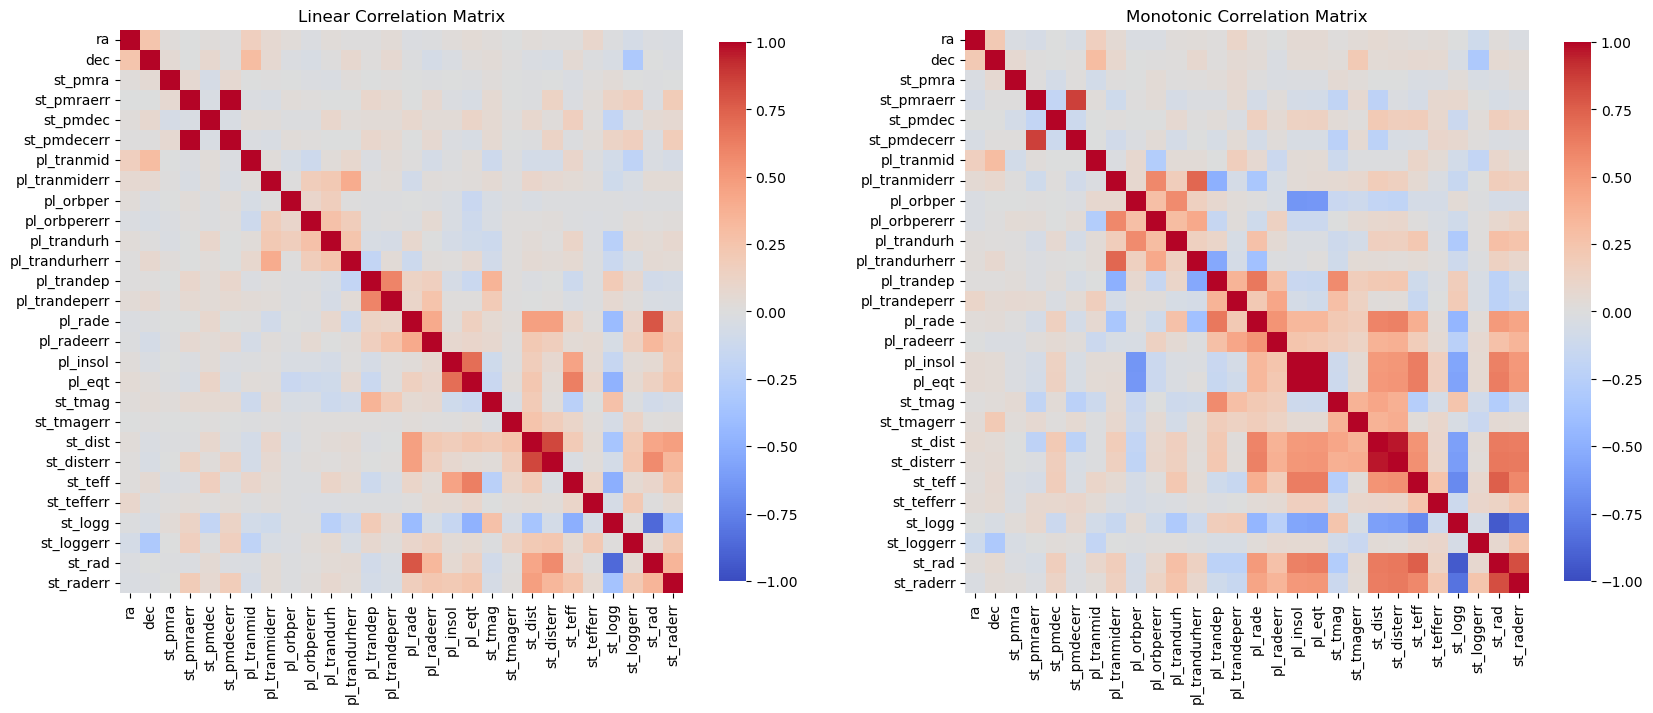

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))  # One row, two columns

# Linear correlation matrix
corr_linear = X_train.corr(method='pearson')
sns.heatmap(corr_linear, cmap='coolwarm', square=True, vmin=-1, vmax=1, cbar=True, ax=axes[0], cbar_kws={'shrink': 0.35})
axes[0].set_title("Linear Correlation Matrix")

# Monotonic correlation matrix
corr_monotonic = X_train.corr(method='spearman')
sns.heatmap(corr_monotonic, cmap='coolwarm', square=True, vmin=-1, vmax=1, cbar=True, ax=axes[1], cbar_kws={'shrink': 0.35})
axes[1].set_title("Monotonic Correlation Matrix")
plt.show()

We can draw several conclusions from these two diagrams:
- Most features do not express strong linear correlations with each other
- The variable pairs (st_dist, st_disterr), (st_rad, st_raderr), and (pl_insol, pl_eqt) express similar correlations within their respective groupings, 
suggesting some redundancy

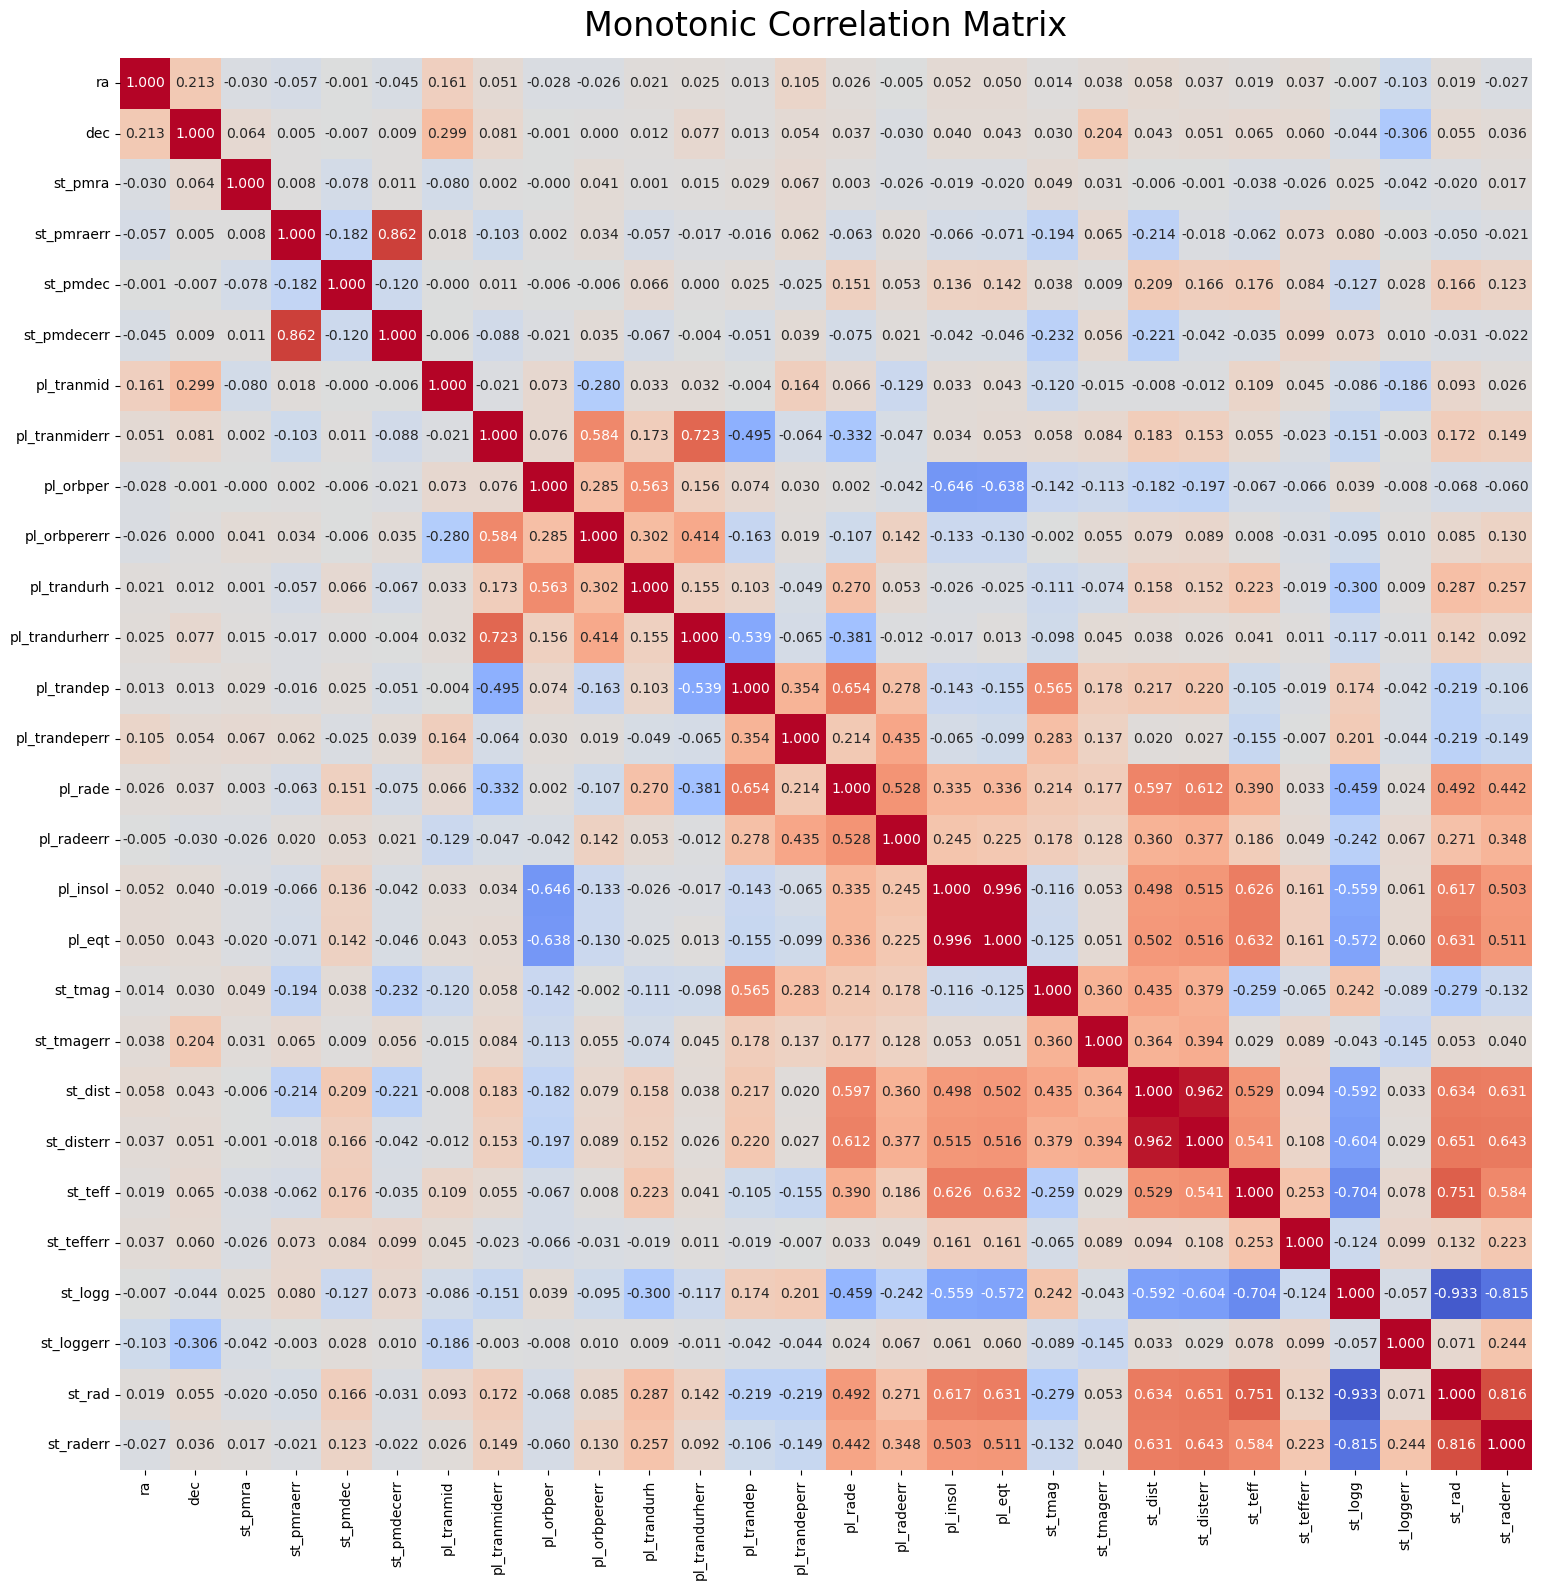

In [ ]:
# Plot the correlation matrix
corr = X_train.corr(method='spearman') # enlarging the spearman correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt=".3f", cmap='coolwarm', square=True, cbar=False)
plt.title("Monotonic Correlation Matrix", fontsize=24, pad=16)
plt.tight_layout()
plt.show()

It is evident that there are sampling biasses in our dataset. For example, there is no natural relationship between predicted planet radius
and its host star's distance from Earth, but the transits of bigger planets are easier to observe. This sampling bias is fascinating, and fortunately
does not impact the validity of our results since the goal is to classify false positives within the table of TESS Objects of Interest, not generalizing
on a natural phenomenon. The bias would be more concering if we were performing a regression task.

### Plotting Feature Relationships
We will create a pairplot to visualize the relationships between the most highly correlated features in the training dataset.

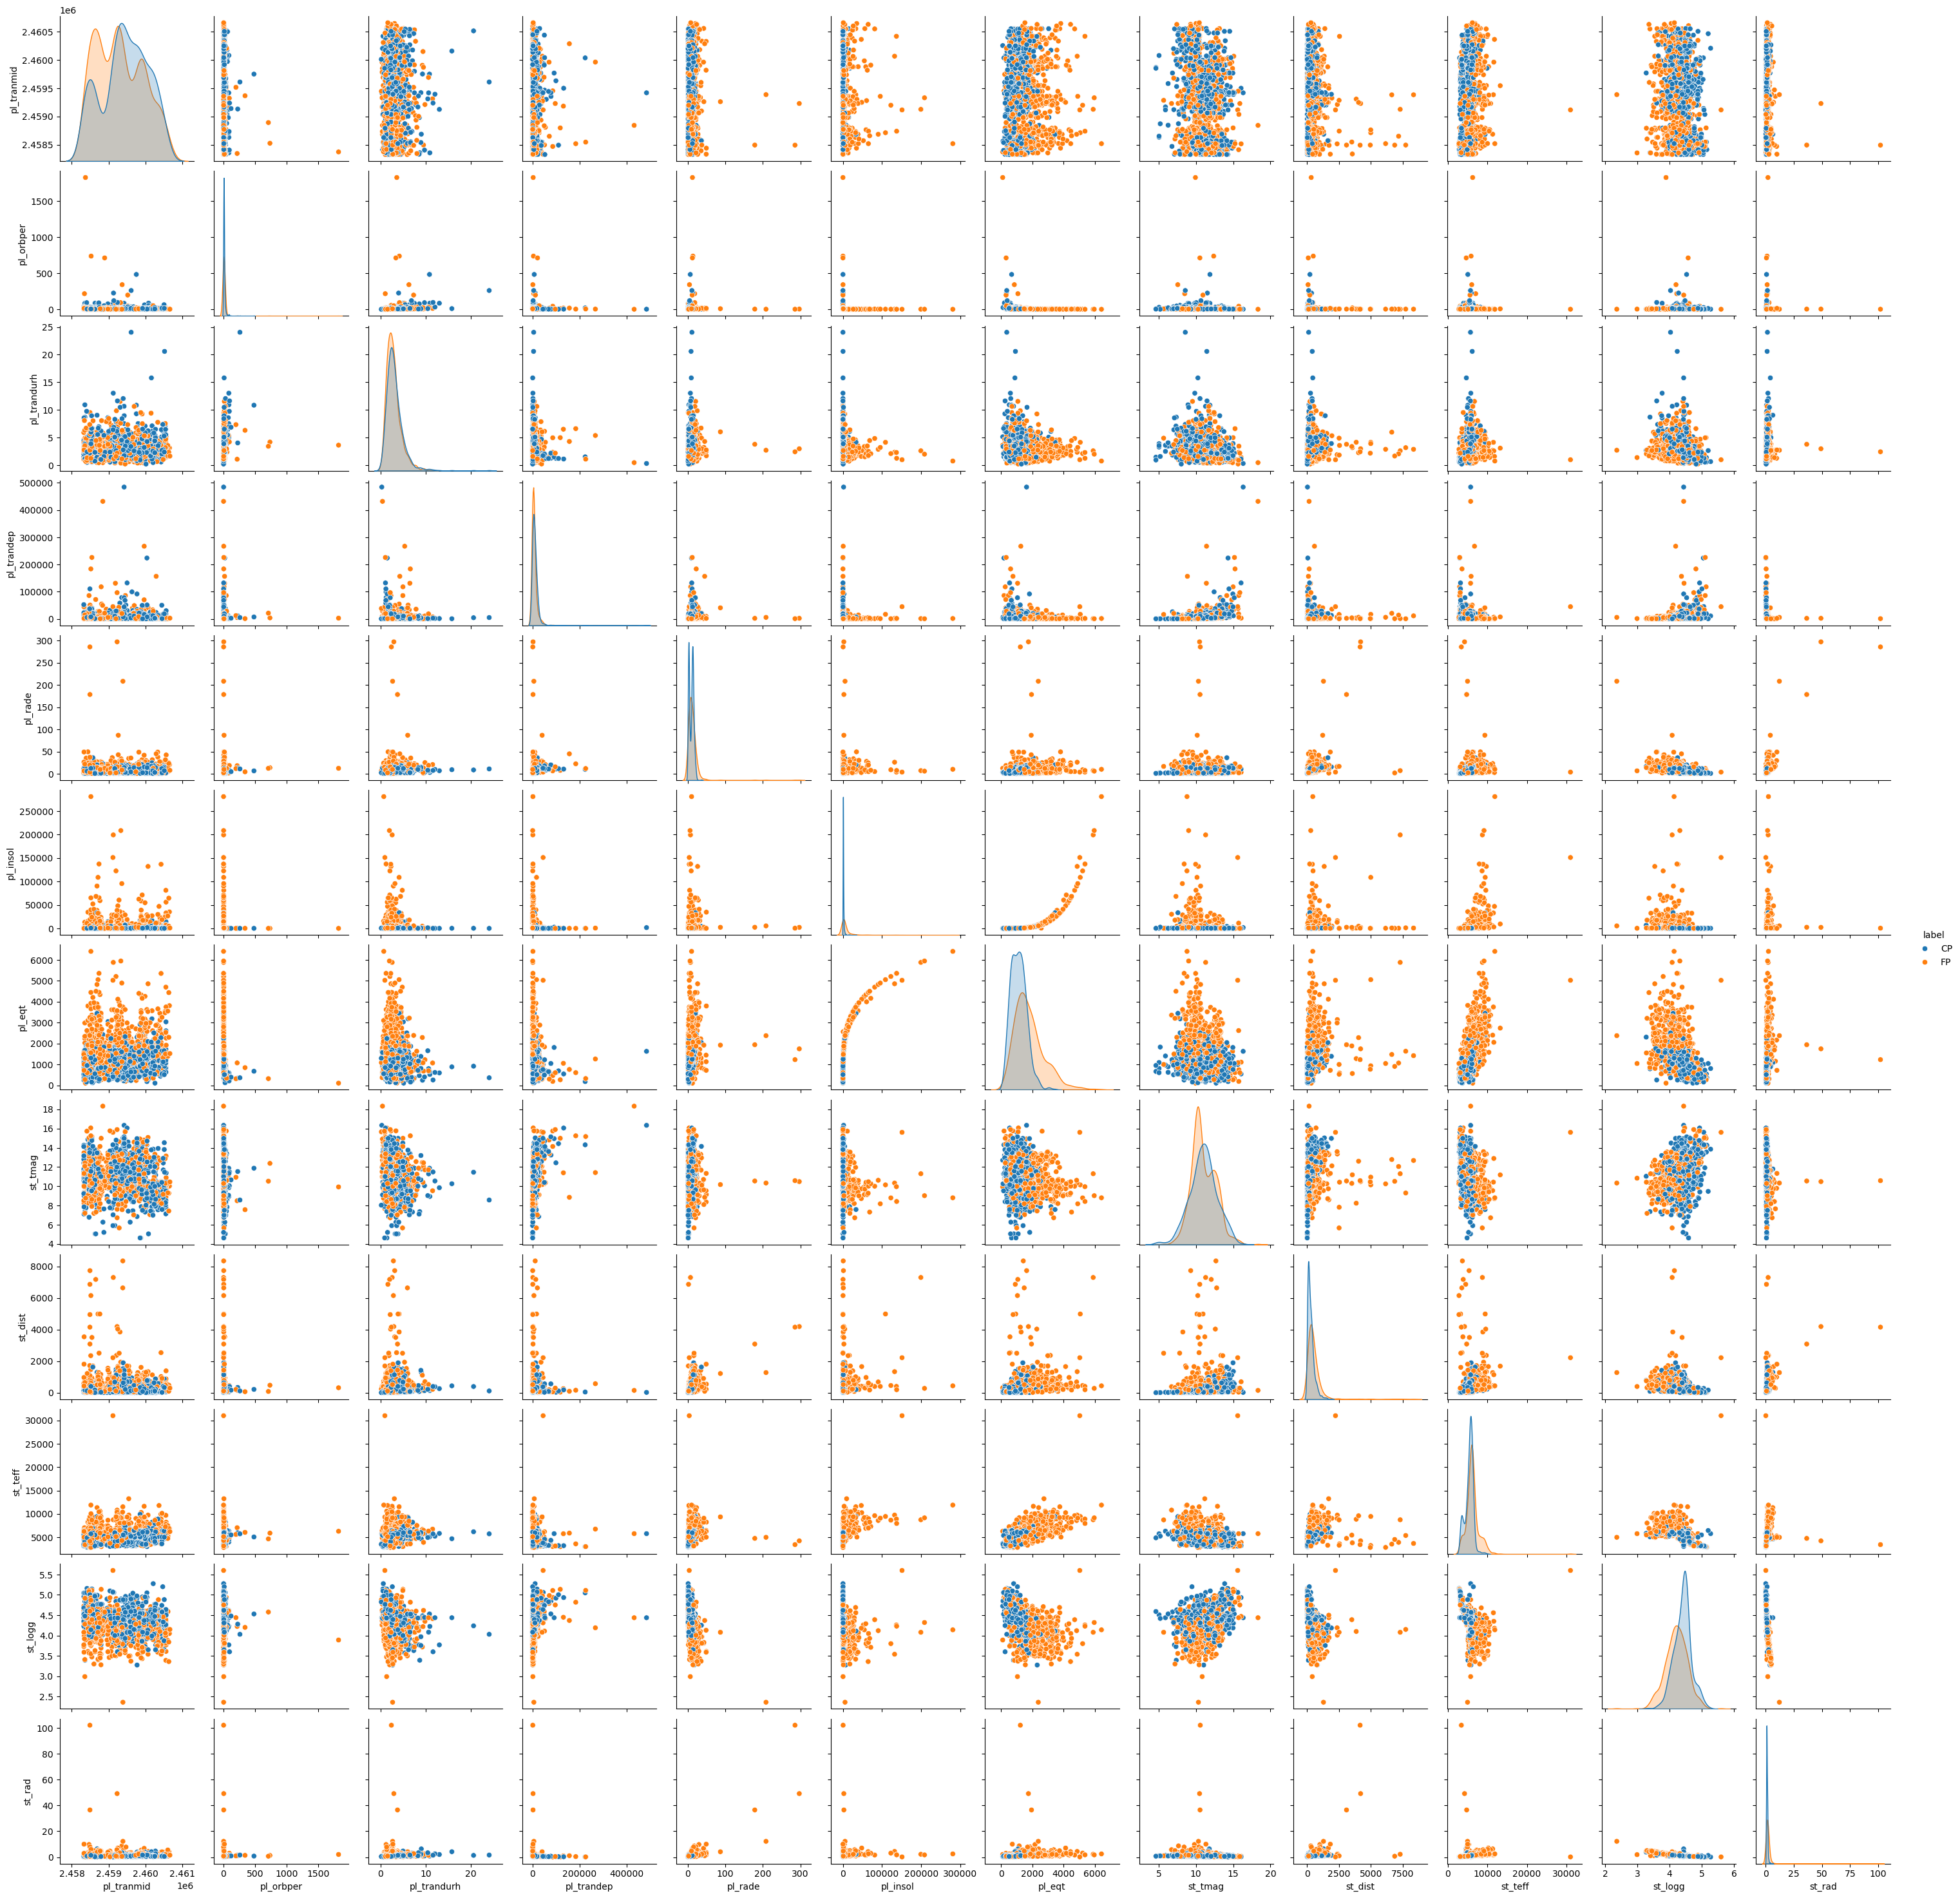

In [ ]:
X_plot = pd.DataFrame(X_train, columns=X.columns).drop(columns=err_cols)
X_plot = X_plot.drop(columns=['ra', 'dec', 'st_pmra', 'st_pmdec'])
X_plot['label'] = binarizer.inverse_transform(y_train)
sns.pairplot(data=X_plot, hue ='label', hue_order=['CP', 'FP'], diag_kind='kde')

## 3.2 - Determining Baseline Performance
We will benchmark the initial performance of our models using 5-fold cross validation. To generate our splits, we will use ``StratifiedKFold`` with ``n_splits=5`` and ``random_state=0``

### Setup of Models and Splits

In [ ]:
# Create our instance of StratifiedKFold with n_splits = 5 and random_state = 0
from sklearn.model_selection import StratifiedKFold
stratified_split = StratifiedKFold(n_splits=5, random_state=0, shuffle=True) # ensure our data is shuffled before splitting

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# use n_jobs = -1 for faster training. 
gradient = XGBClassifier(n_jobs=-1, random_state=0)
svc = SVC(kernel='rbf')
logistic = LogisticRegression(random_state=10, max_iter=10000) # fix the random state
# fixing the random state, and setting n_jobs=-1 to decrease fit time
forest = RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1) 


In [ ]:
# These will be the metrics returned by cross_validate and GridSearchCV
score_types = ['accuracy', 'precision', 'recall']

# This array will allow us to set the display order of the columns in our results DataFrame
score_cols = ['Train Accuracy', 'Validation Accuracy', 'Train Precision','Validation Precision', 'Train Recall','Validation Recall']

### Model Cross Validation

In [ ]:
from sklearn.model_selection import GridSearchCV
models = [logistic, svc, gradient, forest]
model_names = ["LogisticRegression", "SVC", "XGBClassifier", "RandomForestClassifier"]

cv_scores = pd.DataFrame(index=model_names, columns=score_cols)

for i in range (0, len(models)):
    pipeline = None
    if(i <=1):
        pipeline = Pipeline(steps=[
        ('preprocessing', preprocessing), # StandardScaler() + KNNImputer(n_neighbors=5)
        ('estimator', models[i])]) # use StandardScaler()
    else:
        pipeline = Pipeline(steps=[
            # NeutralImputer scales the data, performs KNN imputatation
            # then calls inverse_transform() on the scaler.
            # This allows us to pass unscaled data to the final estimator within a pipeline
            ('preprocessing', neutral), 
            ('estimator', models[i])])
    
    scores = cross_validate(pipeline, X_train, y_train, cv=stratified_split, return_train_score=True, scoring=score_types)
    cv_scores.loc[model_names[i]] = {
        'Train Accuracy': np.mean(scores['train_accuracy']),
        'Validation Accuracy': np.mean(scores['test_accuracy']),
        'Train Precision': np.mean(scores['train_precision']),
        'Validation Precision': np.mean(scores['test_precision']),
        'Train Recall': np.mean(scores['train_recall']),
        'Validation Recall': np.mean(scores['test_recall'])
    }
cv_scores

Train Accuracy Validation Accuracy Train Precision  \
LogisticRegression           0.788596            0.776608        0.823476   
SVC                          0.861111            0.824561        0.903552   
XGBClassifier                     1.0            0.873684             1.0   
RandomForestClassifier            1.0             0.85731             1.0   

                       Validation Precision Train Recall Validation Recall  
LogisticRegression                 0.814954     0.750568           0.73438  
SVC                                0.863716     0.817821          0.786595  
XGBClassifier                      0.881677          1.0          0.873986  
RandomForestClassifier             0.872422          1.0          0.850167

## 3.3 - Examining Feature Importances
We will use 5-fold stratified cross validation to examine the splitting importance of each feature, which will help us understand the results of our tree-based models

<Axes: title={'center': 'RandomForestClassifier'}, xlabel='Importance Score', ylabel='Feature'>

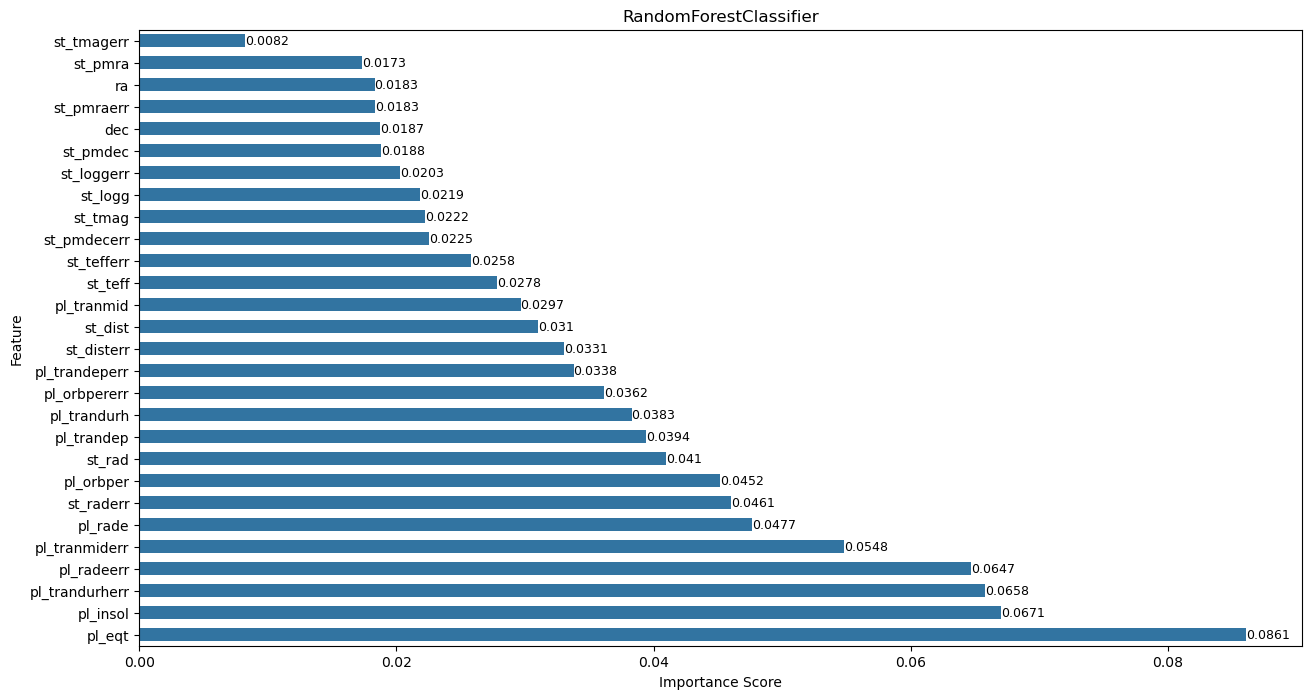

In [ ]:
importance_scores = pd.DataFrame(index=X.columns)
xgb_importance_scores = pd.DataFrame(index=X.columns)
cv_pipe = Pipeline(steps=[('preprocessing', neutral), ('estimator', RandomForestClassifier(random_state=0))])
i = 0
for train, test in stratified_split.split(X_train, y_train):
    X_transform = pd.DataFrame(neutral.fit_transform(X_train), columns=X.columns)
    importance_scores[i] = forest.fit(X_transform, y_train).feature_importances_
    xgb_importance_scores[i] = gradient.fit(X_transform, y_train).feature_importances_
    i += 1

helpers.plot_feature_importances(importances=importance_scores, title='RandomForestClassifier')

<Axes: title={'center': 'XGBClassifier Feature Importances'}, xlabel='Importance Score', ylabel='Feature'>

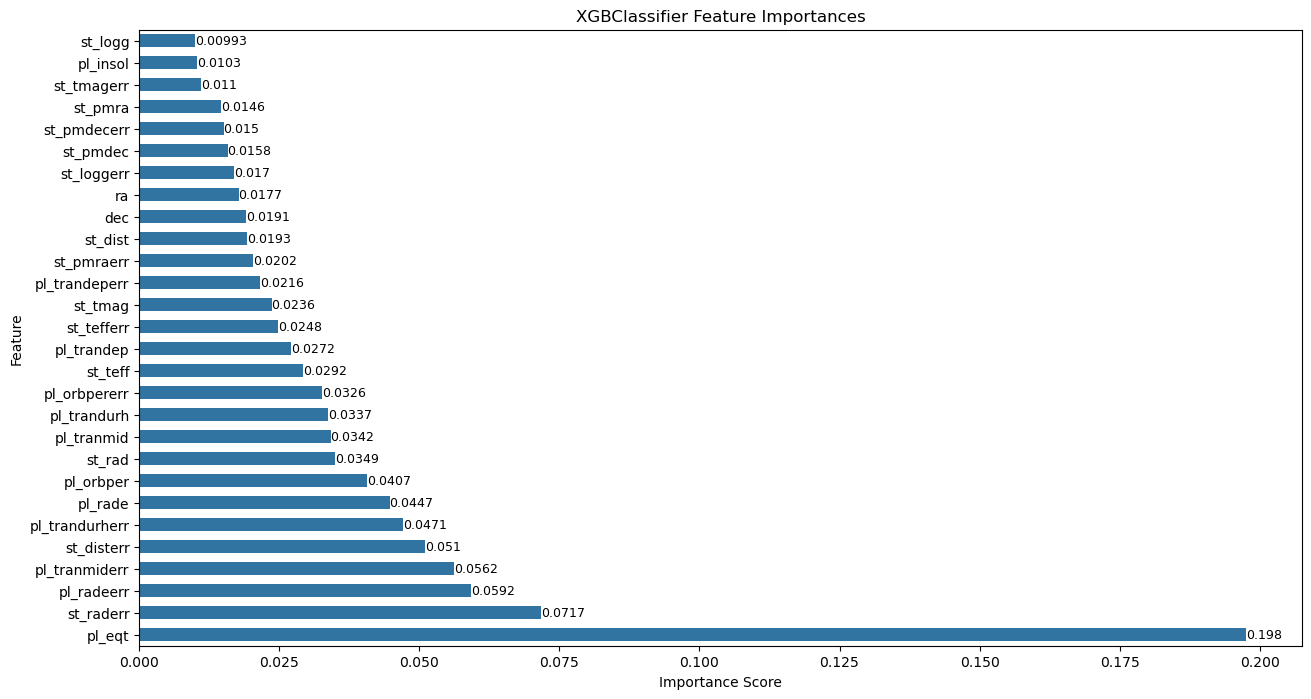

In [ ]:
helpers.plot_feature_importances(xgb_importance_scores, title='XGBClassifier Feature Importances')

### Observations about feature importances
According to the barplots above, the most important feature for splitting the data is ``pl_eqt``, or the equilibrium temperature of the planet. 
The least important feature is ``st_tmagerr``, the uncertainty in the effective magnitude of the star. The plot also shows several features that have equal, or near equal importance, such
as ``ra`` and ``st_pmdec``, and ``st_dist`` and ``st_disterr``. Dropping these features could improve the split quality for the ``RandomForestClassifier``, resulting in higher accuracy.

# Part 4 - Feature Selection and Engineering
In this section, we will investigate whether model performance can be improved by reducing the number of features, or using feature engineering


## 4.1 - Feature Engineering for Logistic Regression
Based on the conclusions from Part 3, the overall performance of the ``LogisticRegression`` model could be improved by 
removing features that are redundant, and adding interaction features to capture the nonlinear relationships in the data.
To generate the interaction features, we will use ``PolynomialFeatures`` with ``degree=2`` and ``interaction_only=True``. 

In part 3, we identified that the features ``st_dist``, ``st_disterr``, ``st_rad``, ``st_raderr``, ``pl_insol``, ``pl_eqt`` are all highly correlated.
|Feature|Real-World Meaning|
|:---:| ---- |
|``st_dist`` | The approximate distance between TESS and the host star, in parsecs. Error measured by ``st_disterr``|
|``st_rad`` | The radius of the star expressed in units of *R[sun]*. Error measured by ``st_raderr``|
|``pl_insol``| The amount of exposure the planet gets to its star's energy, as a multiple of Earth's flux (1361 Watts / m^2) |
|``pl_eqt``| The equilibrium temperature of the planet (assumes the planet radiates as much energy as it receives). Positively correlated with ``pl_insol``|

(the remaining two features represent errors in the measurements of distance and stellar radius, respectively).




[1] https://sunclimate.gsfc.nasa.gov/article/solar-irradiance#:~:text=The%20TSI%20reaching%20Earth%20per,the%20short%20and%20long%20terms.

### Using ``PolynomialFeatures`` for LogisticRegression

Before applying ``PolynomialFeatures`` to ``LogisticRegression``, we should try to reduce the number of irrelevant or redundant features in the dataset. Otherwise, ``PolynomialFeatures`` could
introduce more collinearity that could hinder model performance.

In [ ]:
logistic_drop = ['st_raderr', 'pl_insol', 'st_disterr', 'ra', 'dec', 'st_pmdec', 'st_pmra']
score_display_order = ['Train Accuracy', 'Validation Accuracy', 'Train Precision', 'Validation Precision', 'Train Recall', 'Validation Recall']

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
pipeline = Pipeline(steps=[('preprocessing', preprocessing), ('features', poly), ('estimator', logistic)])
results = cross_validate(pipeline, X_train.drop(columns=logistic_drop), y_train, scoring=['accuracy', 'precision', 'recall'], return_train_score=True, cv=stratified_split, n_jobs=-1)
cv_mapper = {
    'train_accuracy': 'Train Accuracy',
    'test_accuracy': 'Validation Accuracy',
    'train_precision': 'Train Precision',
    'test_precision': 'Validation Precision',
    'train_recall': 'Train Recall',
    'test_recall': 'Validation Recall'
}

scores = helpers.format_cv_results(results, model_name='LogisticRegression', column_mapper=cv_mapper)
scores = scores[score_display_order]
scores.loc['LogisticRegression (base)'] = cv_scores.loc['LogisticRegression']
scores

Train Accuracy  Validation Accuracy  \
LogisticRegression               0.897173             0.839181   
LogisticRegression (base)        0.788596             0.776608   

                           Train Precision  Validation Precision  \
LogisticRegression                0.925139              0.870406   
LogisticRegression (base)         0.823476              0.814954   

                           Train Recall  Validation Recall  
LogisticRegression             0.870864           0.809065  
LogisticRegression (base)      0.750568           0.734380

Introducing polynomial features increased the accuracy of the ``LogisticRegression`` model signficantly, and boosted precision and recall.


## 4.2 Selection Features for ``SVC``

In [ ]:
svc_drop = ['st_tmagerr', 'st_raderr', 'pl_insol', 'st_dist', 'st_pmra', 'st_loggerr', 'st_pmdec',  'st_pmdecerr', 'ra', 'dec']
svc_pipeline = Pipeline(steps=[('preprocessing', preprocessing), ('estimator', svc)])
results = cross_validate(svc_pipeline, X_train.drop(columns=svc_drop), y_train, scoring=['accuracy', 'precision', 'recall'], return_train_score=True, cv=stratified_split, n_jobs=-1)
results = helpers.format_cv_results(results, model_name='SVC', column_mapper=cv_mapper)[score_display_order]
results.loc['SVC (baseline)'] = cv_scores.loc['SVC']
results

Train Accuracy  Validation Accuracy  Train Precision  \
SVC                   0.856481             0.827485         0.899446   
SVC (baseline)        0.861111             0.824561         0.903552   

                Validation Precision  Train Recall  Validation Recall  
SVC                         0.856740      0.812207           0.799649  
SVC (baseline)              0.863716      0.817821           0.786595

## 4.3 Feature Selection for ``XGBClassifier``

In [ ]:
# It is unfortunately not clear why dropping this specific column improved model accuracy.
xgb_drop = ['st_raderr']
xgb_pipeline = Pipeline(steps=[('preprocessing', neutral), ('estimator', gradient)])
results = cross_validate(xgb_pipeline, X_train.drop(columns=xgb_drop), y_train, scoring=['accuracy', 'precision', 'recall'], return_train_score=True, cv=stratified_split, n_jobs=-1)
results = helpers.format_cv_results(results, model_name='XGBClassifier', column_mapper=cv_mapper)[score_display_order]
results.loc['XGBClassifier (baseline)'] = cv_scores.loc['XGBClassifier']
results

Train Accuracy  Validation Accuracy  \
XGBClassifier                        1.0             0.888889   
XGBClassifier (baseline)             1.0             0.873684   

                          Train Precision  Validation Precision  Train Recall  \
XGBClassifier                         1.0              0.892646           1.0   
XGBClassifier (baseline)              1.0              0.881677           1.0   

                          Validation Recall  
XGBClassifier                      0.894143  
XGBClassifier (baseline)           0.873986

## 4.4 - Selecting Features for RandomForestClassifier
To improve the quality of the splits for our RandomForest model, we will experiment with dropping different features. These features *may* be ones that
have low importance, or are highly correlated, and therefore redundant.

In [ ]:
# This set of features was partially selected based on the plotted feature importances
# but also via brute force (adding or removing features and rerunning the code). 
# Most of these features were of low importance, or had equal importance to another low-importance features
# The st_tmagerr column has extremely low variance, which makes it not very useful for splitting
forest_drop = ['st_tmagerr', 'st_raderr', 'st_disterr', 'st_pmra', 'st_loggerr', 'st_pmdec', 'st_pmdecerr', 'ra']
forest_pipeline = Pipeline(steps=[('preprocessing', neutral), ('estimator', forest)])
results = cross_validate(forest_pipeline, X_train.drop(columns=forest_drop), y_train, scoring=['accuracy', 'precision', 'recall'], return_train_score=True, cv=stratified_split, n_jobs=-1)
results = helpers.format_cv_results(results, model_name='RandomForestClassifier', column_mapper=cv_mapper)[score_display_order]
results.loc['RandomForestClassifier (baseline)'] = cv_scores.loc['RandomForestClassifier']
results

Train Accuracy  Validation Accuracy  \
RandomForestClassifier                        1.0              0.87037   
RandomForestClassifier (baseline)             1.0              0.85731   

                                   Train Precision  Validation Precision  \
RandomForestClassifier                         1.0              0.874653   
RandomForestClassifier (baseline)              1.0              0.872422   

                                   Train Recall  Validation Recall  
RandomForestClassifier                      1.0           0.875257  
RandomForestClassifier (baseline)           1.0           0.850167

# Part 5 - Hyperparameter Tuning

This section will focus on finding the optimal hyperparameters for each model using a grid search. 

In [ ]:
## Create a dataframe to store our results
columns = [
    'params',
    'mean_train_accuracy',
    'mean_test_accuracy',
    'mean_train_precision',
    'mean_test_precision',
    'mean_train_recall',
    'mean_test_recall',
]
grid_search_results = pd.DataFrame(index=['LogisticRegression', 'SVC', 'XGBClassifier', 'RandomForestClassifier'], columns=columns)
best_estimators = {}

## 5.1 - LogisticRegression
In this section, we will tune the hyperparameters on our LogisticRegression model from Part 2 that was trained on the dataset that included interaction features.

In [ ]:
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
grid_pipeline = Pipeline(steps=[('preprocessing', preprocessing), ('features', poly), ('estimator', logistic)]) 
param_grid = {
    'estimator__max_iter': [100, 10000, 20000],
    'estimator__C': [1, 5e-1, 1e-1, 5e-2, 1e-2], # inverse regularization strength
    'estimator__tol': [1e-1, 1e-2, 1e-3],
    'estimator__penalty': ['l1', 'l2'],
    'estimator__solver':['liblinear', 'lbfgs'],
    'estimator__random_state': [10]
}
grid_search_logistic = GridSearchCV(grid_pipeline, param_grid = param_grid, scoring=['accuracy', 'precision', 'recall'], refit='accuracy', return_train_score=True, n_jobs=-1, error_score=np.nan)
X_train_logistic = X_train.drop(columns=logistic_drop)
grid_search_logistic.fit(X_train_logistic, y_train)
best_estimators['LogisticRegression'] = grid_search_logistic.best_estimator_
logistic_results = pd.DataFrame(grid_search_logistic.cv_results_)

In [ ]:
logistic_results = logistic_results.sort_values(by=['rank_test_accuracy', 'rank_test_precision'])
grid_search_results.loc['LogisticRegression'] = logistic_results.iloc[0][columns]
logistic_results[columns].head(n=10)

params  \
37    {'estimator__C': 0.5, 'estimator__max_iter': 100, 'estimator__penalty': 'l1', 'estimator__random_state': 10, 'estimator__solver': 'liblinear', 'estimator__tol': 0.01}   
49  {'estimator__C': 0.5, 'estimator__max_iter': 10000, 'estimator__penalty': 'l1', 'estimator__random_state': 10, 'estimator__solver': 'liblinear', 'estimator__tol': 0.01}   
61  {'estimator__C': 0.5, 'estimator__max_iter': 20000, 'estimator__penalty': 'l1', 'estimator__random_state': 10, 'estimator__solver': 'liblinear', 'estimator__tol': 0.01}   
1       {'estimator__C': 1, 'estimator__max_iter': 100, 'estimator__penalty': 'l1', 'estimator__random_state': 10, 'estimator__solver': 'liblinear', 'estimator__tol': 0.01}   
13    {'estimator__C': 1, 'estimator__max_iter': 10000, 'estimator__penalty': 'l1', 'estimator__random_state': 10, 'estimator__solver': 'liblinear', 'estimator__tol': 0.01}   
25    {'estimator__C': 1, 'estimator__max_iter': 20000, 'estimator__penalty': 'l1', 'estimator__random_state': 10, 'estimator__solver': 'liblinear', 'estimator__tol': 0.01}   
47       {'estimator__C': 0.5, 'estimator__max_iter': 100, 'estimator__penalty': 'l2', 'estimator__random_state': 10, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.001}   
59     {'estimator__C': 0.5, 'estimator__max_iter': 10000, 'estimator__penalty': 'l2', 'estimator__random_state': 10, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.001}   
71     {'estimator__C': 0.5, 'estimator__max_iter': 20000, 'estimator__penalty': 'l2', 'estimator__random_state': 10, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.001}   
46        {'estimator__C': 0.5, 'estimator__max_iter': 100, 'estimator__penalty': 'l2', 'estimator__random_state': 10, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.01}   

    mean_train_accuracy  mean_test_accuracy  mean_train_precision  \
37             0.879971            0.846199              0.914482   
49             0.879971            0.846199              0.914482   
61             0.879971            0.846199              0.914482   
1              0.889474            0.845029              0.919661   
13             0.889474            0.845029              0.919661   
25             0.889474            0.845029              0.919661   
47             0.889327            0.843860              0.920918   
59             0.889327            0.843860              0.920918   
71             0.889327            0.843860              0.920918   
46             0.881871            0.842690              0.914348   

    mean_test_precision  mean_train_recall  mean_test_recall  
37             0.884875           0.846199          0.807056  
49             0.884875           0.846199          0.807056  
61             0.884875           0.846199          0.807056  
1              0.880413           0.860672          0.809335  
13             0.880413           0.860672          0.809335  
25             0.880413           0.860672          0.809335  
47             0.874540           0.858969          0.813855  
59             0.874540           0.858969          0.813855  
71             0.874540           0.858969          0.813855  
46             0.877081           0.850455          0.808186

## 5.2 - XGBClassifier

``XGBClassifier`` is a robust implementation of a gradient-boosted classifier. It is similar to ``sklearn.ensemble.GradientBoostingClassifier``, but
with superior out-of-the-box performance. In this project, the following additional hyperparameters will be used to tune the model, which are not available in scikit learn:
|Hyperparameter       | Function                                                                             |
|:--------------------|-------------------------------------------------------------------------------------:|
|``gamma``            | The minimum reduction in the loss function required to split a leaf node             |
|``lambda``           | Strength of L2 regularization applied to leaf weights                                |
|``colsample_bylevel``| Fraction of all features sampled at each level, selected at random                   |
|``colsample_bytree`` | Fraction of all features sampled at each tree, selected at random                    |
|``colsample_bynode`` | Fraction of all features sampled at each node, selected at random                    |

These hyperparameters help to control overfitting and improve the ability of the model to generalize by favouring more conservative splits and introducing
randomness into the trees

In [ ]:
# The original grid search spanned a larger parameter range than what is show here
# This has been simplified to show the same effect but reduce runtime
xgb_pipe = Pipeline(steps=[('preprocessing', neutral), ('estimator', gradient)]) # the neutral imputer un-scales the data after imputing since tree-based models do not require scaling
param_grid = {
    'estimator__gamma':[1, 0.1, 0.01], # minimum loss before pruning
    'estimator__lambda':[1, 10, 100], # L2 regularization applied to leaf weights
    'estimator__colsample_bylevel': [0.7, 0.9], # fraction of all features sampled at each level. 
    'estimator__colsample_bytree': [0.6, 0.8], # fraction of the total number of features sampled by each tree
    'estimator__colsample_bynode': [0.7, 0.9],  #fraction of all features sampled at each node: n_cols * (bylevel * bytree * bynode)
    'estimator__n_estimators':[500], # number of boosting rounds
}
grid_search_xgb = GridSearchCV(xgb_pipe, cv=stratified_split, n_jobs=-1, refit='accuracy', param_grid=param_grid, return_train_score=True, scoring=['accuracy', 'precision', 'recall'])
grid_search_xgb.fit(X_train.drop(columns=xgb_drop), y_train)
best_estimators['XGBClassifier'] = grid_search_xgb.best_estimator_

In [ ]:
grid_results = pd.DataFrame(grid_search_xgb.cv_results_)
grid_results = grid_results.sort_values(by=['rank_test_accuracy', 'rank_test_recall'])
grid_search_results.loc['XGBClassifier'] = grid_results.iloc[0][columns]
grid_results[columns].head(n=10)

params  \
34   {'estimator__colsample_bylevel': 0.7, 'estimator__colsample_bynode': 0.9, 'estimator__colsample_bytree': 0.8, 'estimator__gamma': 0.01, 'estimator__lambda': 10, 'estimator__n_estimators': 500}   
52   {'estimator__colsample_bylevel': 0.9, 'estimator__colsample_bynode': 0.7, 'estimator__colsample_bytree': 0.8, 'estimator__gamma': 0.01, 'estimator__lambda': 10, 'estimator__n_estimators': 500}   
69    {'estimator__colsample_bylevel': 0.9, 'estimator__colsample_bynode': 0.9, 'estimator__colsample_bytree': 0.8, 'estimator__gamma': 0.01, 'estimator__lambda': 1, 'estimator__n_estimators': 500}   
43   {'estimator__colsample_bylevel': 0.9, 'estimator__colsample_bynode': 0.7, 'estimator__colsample_bytree': 0.6, 'estimator__gamma': 0.01, 'estimator__lambda': 10, 'estimator__n_estimators': 500}   
23   {'estimator__colsample_bylevel': 0.7, 'estimator__colsample_bynode': 0.9, 'estimator__colsample_bytree': 0.6, 'estimator__gamma': 0.1, 'estimator__lambda': 100, 'estimator__n_estimators': 500}   
62  {'estimator__colsample_bylevel': 0.9, 'estimator__colsample_bynode': 0.9, 'estimator__colsample_bytree': 0.6, 'estimator__gamma': 0.01, 'estimator__lambda': 100, 'estimator__n_estimators': 500}   
25   {'estimator__colsample_bylevel': 0.7, 'estimator__colsample_bynode': 0.9, 'estimator__colsample_bytree': 0.6, 'estimator__gamma': 0.01, 'estimator__lambda': 10, 'estimator__n_estimators': 500}   
22    {'estimator__colsample_bylevel': 0.7, 'estimator__colsample_bynode': 0.9, 'estimator__colsample_bytree': 0.6, 'estimator__gamma': 0.1, 'estimator__lambda': 10, 'estimator__n_estimators': 500}   
8   {'estimator__colsample_bylevel': 0.7, 'estimator__colsample_bynode': 0.7, 'estimator__colsample_bytree': 0.6, 'estimator__gamma': 0.01, 'estimator__lambda': 100, 'estimator__n_estimators': 500}   
4     {'estimator__colsample_bylevel': 0.7, 'estimator__colsample_bynode': 0.7, 'estimator__colsample_bytree': 0.6, 'estimator__gamma': 0.1, 'estimator__lambda': 10, 'estimator__n_estimators': 500}   

    mean_train_accuracy  mean_test_accuracy  mean_train_precision  \
34             1.000000            0.881287              1.000000   
52             1.000000            0.880117              1.000000   
69             1.000000            0.878947              1.000000   
43             1.000000            0.878363              1.000000   
23             0.990351            0.877778              0.991192   
62             1.000000            0.877193              1.000000   
25             1.000000            0.877193              1.000000   
22             1.000000            0.877193              1.000000   
8              1.000000            0.876608              1.000000   
4              1.000000            0.876608              1.000000   

    mean_test_precision  mean_train_recall  mean_test_recall  
34             0.884814           1.000000          0.886479  
52             0.886458           1.000000          0.881940  
69             0.887230           1.000000          0.878531  
43             0.884023           1.000000          0.880810  
23             0.885479           0.990069          0.878525  
62             0.882754           1.000000          0.880791  
25             0.884001           1.000000          0.878531  
22             0.882777           1.000000          0.880791  
8              0.881774           1.000000          0.880797  
4              0.884046           1.000000          0.877401

## 5.3 - SVC

In [ ]:
# implementing the grid search for svc
svc_pipeline = Pipeline(steps=[('scaler', standard), ('imputer', imputer), ('estimator', SVC())])
grid_cv_svc = GridSearchCV(svc_pipeline, param_grid={
    'estimator__random_state': [42],
    'estimator__gamma': ['scale', 'auto', 100, 10, 1, 1e-1, 1e-2, 1e-3],
    'estimator__tol':[1e-3, 1e-2, 1e-1],
    'estimator__C': [100, 10, 1e-1, 1e-2, 1e-3],
    'estimator__kernel': ['rbf'], # leaving the kernel as RBF 
}, n_jobs=-1, refit='accuracy', return_train_score=True, cv=stratified_split, scoring=['accuracy', 'precision', 'recall'])
grid_cv_svc.fit(X_train.drop(columns=svc_drop), y_train)
best_estimators['SVC'] = grid_cv_svc.best_estimator_
svc_results = pd.DataFrame(grid_cv_svc.cv_results_)

In [ ]:
svc_results=svc_results.sort_values(by=['rank_test_accuracy', 'rank_test_precision'])[columns]
grid_search_results.loc['SVC'] = svc_results.iloc[0][columns]
svc_results.head(n=10) # print the top 10 best results

params  \
29     {'estimator__C': 10, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'estimator__random_state': 42, 'estimator__tol': 0.1}   
41        {'estimator__C': 10, 'estimator__gamma': 0.1, 'estimator__kernel': 'rbf', 'estimator__random_state': 42, 'estimator__tol': 0.1}   
26    {'estimator__C': 10, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf', 'estimator__random_state': 42, 'estimator__tol': 0.1}   
39      {'estimator__C': 10, 'estimator__gamma': 0.1, 'estimator__kernel': 'rbf', 'estimator__random_state': 42, 'estimator__tol': 0.001}   
40       {'estimator__C': 10, 'estimator__gamma': 0.1, 'estimator__kernel': 'rbf', 'estimator__random_state': 42, 'estimator__tol': 0.01}   
24  {'estimator__C': 10, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf', 'estimator__random_state': 42, 'estimator__tol': 0.001}   
25   {'estimator__C': 10, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf', 'estimator__random_state': 42, 'estimator__tol': 0.01}   
27   {'estimator__C': 10, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'estimator__random_state': 42, 'estimator__tol': 0.001}   
28    {'estimator__C': 10, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'estimator__random_state': 42, 'estimator__tol': 0.01}   
20      {'estimator__C': 100, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf', 'estimator__random_state': 42, 'estimator__tol': 0.1}   

    mean_train_accuracy  mean_test_accuracy  mean_train_precision  \
29             0.910088            0.856725              0.940665   
41             0.934357            0.856725              0.956100   
26             0.910526            0.855556              0.940170   
39             0.935380            0.855556              0.956998   
40             0.935088            0.855556              0.956973   
24             0.910819            0.854971              0.940740   
25             0.911111            0.854971              0.941040   
27             0.910380            0.854971              0.940159   
28             0.910234            0.854971              0.940143   
20             0.887135            0.853801              0.920788   

    mean_test_precision  mean_train_recall  mean_test_recall  
29             0.881915           0.881103          0.834284  
41             0.870342           0.914588          0.849031  
26             0.880717           0.882523          0.833147  
39             0.868396           0.915723          0.849031  
40             0.868396           0.915155          0.849031  
24             0.878814           0.882523          0.834284  
25             0.878814           0.882807          0.834284  
27             0.878814           0.882240          0.834284  
28             0.878814           0.881956          0.834284  
20             0.890217           0.854429          0.818407

## 5.4 - RandomForestClassifier

In [ ]:
forest_pipeline = Pipeline(steps=[('preprocessing', neutral), ('estimator', forest)])
param_grid = {
    'estimator__n_estimators':[100],
    'estimator__max_depth':[20, 40],
    'estimator__min_samples_split':[2, 4, 8],
    'estimator__min_samples_leaf':[1, 2, 4, 8],
    'estimator__min_impurity_decrease':[1e-3, 1e-4],
    'estimator__max_samples':[0.8]
}
grid_cv_forest = GridSearchCV(forest_pipeline, param_grid=param_grid, scoring=['accuracy', 'precision', 'recall'], refit='accuracy', return_train_score=True, n_jobs=-1, cv=stratified_split)
grid_cv_forest.fit(X_train.drop(columns=forest_drop), y_train)
best_estimators['RandomForestClassifier'] = grid_cv_forest.best_estimator_
forest_results = pd.DataFrame(grid_cv_forest.cv_results_)

In [ ]:
# Print the top 10 best results, sorted by accuracy
forest_results = forest_results.sort_values(by=['rank_test_accuracy', 'rank_test_precision'])
grid_search_results.loc['RandomForestClassifier'] = forest_results.iloc[0][columns]
forest_results[columns].head(n=10)

params  \
12  {'estimator__max_depth': 20, 'estimator__max_samples': 0.8, 'estimator__min_impurity_decrease': 0.0001, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100}   
36  {'estimator__max_depth': 40, 'estimator__max_samples': 0.8, 'estimator__min_impurity_decrease': 0.0001, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100}   
1    {'estimator__max_depth': 20, 'estimator__max_samples': 0.8, 'estimator__min_impurity_decrease': 0.001, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 4, 'estimator__n_estimators': 100}   
25   {'estimator__max_depth': 40, 'estimator__max_samples': 0.8, 'estimator__min_impurity_decrease': 0.001, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 4, 'estimator__n_estimators': 100}   
13  {'estimator__max_depth': 20, 'estimator__max_samples': 0.8, 'estimator__min_impurity_decrease': 0.0001, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 4, 'estimator__n_estimators': 100}   
37  {'estimator__max_depth': 40, 'estimator__max_samples': 0.8, 'estimator__min_impurity_decrease': 0.0001, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 4, 'estimator__n_estimators': 100}   
15  {'estimator__max_depth': 20, 'estimator__max_samples': 0.8, 'estimator__min_impurity_decrease': 0.0001, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100}   
16  {'estimator__max_depth': 20, 'estimator__max_samples': 0.8, 'estimator__min_impurity_decrease': 0.0001, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 4, 'estimator__n_estimators': 100}   
39  {'estimator__max_depth': 40, 'estimator__max_samples': 0.8, 'estimator__min_impurity_decrease': 0.0001, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100}   
40  {'estimator__max_depth': 40, 'estimator__max_samples': 0.8, 'estimator__min_impurity_decrease': 0.0001, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 4, 'estimator__n_estimators': 100}   

    mean_train_accuracy  mean_test_accuracy  mean_train_precision  \
12             0.999561            0.862573              0.999716   
36             0.999561            0.861988              0.999716   
1              0.973977            0.861404              0.979655   
25             0.973977            0.861404              0.979655   
13             0.996345            0.861404              0.996882   
37             0.996345            0.861404              0.996882   
15             0.988596            0.859064              0.988945   
16             0.988596            0.859064              0.988945   
39             0.988596            0.859064              0.988945   
40             0.988596            0.859064              0.988945   

    mean_test_precision  mean_train_recall  mean_test_recall  
12             0.873359           0.999432          0.859239  
36             0.873208           0.999432          0.858102  
1              0.879634           0.969637          0.849018  
25             0.879634           0.969637          0.849018  
13             0.874528           0.996026          0.855836  
37             0.874528           0.996026          0.855836  
15             0.874952           0.988932          0.850154  
16             0.874952           0.988932          0.850154  
39             0.874952           0.988932          0.850154  
40             0.874952           0.988932          0.850154

## 5.5 - Summary of Grid Search Results
The table below summarizes the results of all four hyperparameter grid searches.

In [ ]:
grid_search_results

params  \
LogisticRegression                                            {'estimator__C': 0.5, 'estimator__max_iter': 100, 'estimator__penalty': 'l1', 'estimator__random_state': 10, 'estimator__solver': 'liblinear', 'estimator__tol': 0.01}   
SVC                                                                                               {'estimator__C': 10, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf', 'estimator__random_state': 42, 'estimator__tol': 0.1}   
XGBClassifier                       {'estimator__colsample_bylevel': 0.7, 'estimator__colsample_bynode': 0.9, 'estimator__colsample_bytree': 0.8, 'estimator__gamma': 0.01, 'estimator__lambda': 10, 'estimator__n_estimators': 500}   
RandomForestClassifier  {'estimator__max_depth': 20, 'estimator__max_samples': 0.8, 'estimator__min_impurity_decrease': 0.0001, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100}   

                       mean_train_accuracy mean_test_accuracy  \
LogisticRegression                0.879971           0.846199   
SVC                               0.910088           0.856725   
XGBClassifier                          1.0           0.881287   
RandomForestClassifier            0.999561           0.862573   

                       mean_train_precision mean_test_precision  \
LogisticRegression                 0.914482            0.884875   
SVC                                0.940665            0.881915   
XGBClassifier                           1.0            0.884814   
RandomForestClassifier             0.999716            0.873359   

                       mean_train_recall mean_test_recall  
LogisticRegression              0.846199         0.807056  
SVC                             0.881103         0.834284  
XGBClassifier                        1.0         0.886479  
RandomForestClassifier          0.999432         0.859239

# Part 6 Final Predictions and Results
The investigation will conclude by evaluting the performance of each model on the testing set, using the most combinations of features and hyperparameters determined
in the previous sections. Since``GridSearchCV`` was used with ``refit='accuracy'`` enabled, our best models can be tested without calling ``fit()``, saving a bit of computation time. 

In [ ]:
# Setup
from sklearn.metrics import classification_report, confusion_matrix

def recover_labels(y_true, y_pred):
    return binarizer.inverse_transform(y_true), binarizer.inverse_transform(y_pred)

def add_score_row(scores_df, scores_dict, model_name):
    '''This function is required to append a new row to the final scores DataFrame.
    It is a single-use function. Although our columns match with the dict keys, Python doesn't accept
    df.loc['new_row'] = [dict]. '''
    scores_df.loc[model_name] = {
        'Train Accuracy': scores_dict['Train Accuracy'],
        'Test Accuracy': scores_dict['Test Accuracy'],
        'Train Precision': scores_dict['Train Precision'],
        'Test Precision': scores_dict['Test Precision'],
        'Train Recall': scores_dict['Train Recall'],
        'Test Recall': scores_dict['Test Recall']
    }

final_scores = pd.DataFrame(columns=['Train Accuracy', 'Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall', 'Test Recall'])
y_true = binarizer.inverse_transform(y_test)
predictions = {}

## 6.1 - Final Predictions

### LogisticRegression

In [ ]:
final_logistic = best_estimators['LogisticRegression'] # don't overwrite the original models, in case something goes wrong
X_train_logistic = X_train.drop(columns=logistic_drop)
X_test_logistic = X_test.drop(columns=logistic_drop)
scores, y_pred = helpers.assess_model(final_logistic, X_train_logistic, y_train, X_test_logistic, y_test)
y_true, y_pred = recover_labels(y_test, y_pred)
add_score_row(final_scores, scores, 'LogisticRegression')
predictions['LogisticRegression'] = y_pred
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          CP       0.83      0.89      0.86       208
          FP       0.89      0.83      0.86       220

    accuracy                           0.86       428
   macro avg       0.86      0.86      0.86       428
weighted avg       0.86      0.86      0.86       428



### SVC

In [ ]:
final_svc = best_estimators['SVC']
X_train_svc = X_train.drop(columns=svc_drop)
X_test_svc = X_test.drop(columns=svc_drop)
scores, y_pred = helpers.assess_model(final_svc, X_train_svc, y_train, X_test_svc, y_test)
y_true, y_pred = recover_labels(y_test, y_pred)
predictions['SVC'] = y_pred
add_score_row(final_scores, scores, 'SVC')
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          CP       0.84      0.89      0.87       208
          FP       0.89      0.85      0.87       220

    accuracy                           0.87       428
   macro avg       0.87      0.87      0.87       428
weighted avg       0.87      0.87      0.87       428



### XGBClassifier

In [ ]:
final_xgb = best_estimators['XGBClassifier']
scores, y_pred = helpers.assess_model(final_xgb, X_train.drop(columns=xgb_drop), y_train, X_test.drop(columns=xgb_drop), y_test)
y_true, y_pred = recover_labels(y_test, y_pred)
add_score_row(final_scores, scores, 'XGBClassifier')
predictions['XGBClassifier'] = y_pred
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          CP       0.88      0.91      0.90       208
          FP       0.91      0.89      0.90       220

    accuracy                           0.90       428
   macro avg       0.90      0.90      0.90       428
weighted avg       0.90      0.90      0.90       428



### RandomForestClassifier

In [ ]:
final_forest = best_estimators['RandomForestClassifier']
X_train_forest = X_train.drop(columns=forest_drop)
X_test_forest = X_test.drop(columns=forest_drop)
scores, y_pred = helpers.assess_model(final_forest, X_train_forest, y_train, X_test_forest, y_test)
y_true, y_pred = recover_labels(y_test, y_pred)
add_score_row(final_scores, scores, 'RandomForestClassifier')
predictions['RandomForestClassifier'] = y_pred
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          CP       0.88      0.89      0.89       208
          FP       0.90      0.89      0.89       220

    accuracy                           0.89       428
   macro avg       0.89      0.89      0.89       428
weighted avg       0.89      0.89      0.89       428



## 6.2 - Visualization of Results

### Using confusion matrices to visualize performance

We will print confusion matrices for each model to help visualize the prediction results and compare model performance

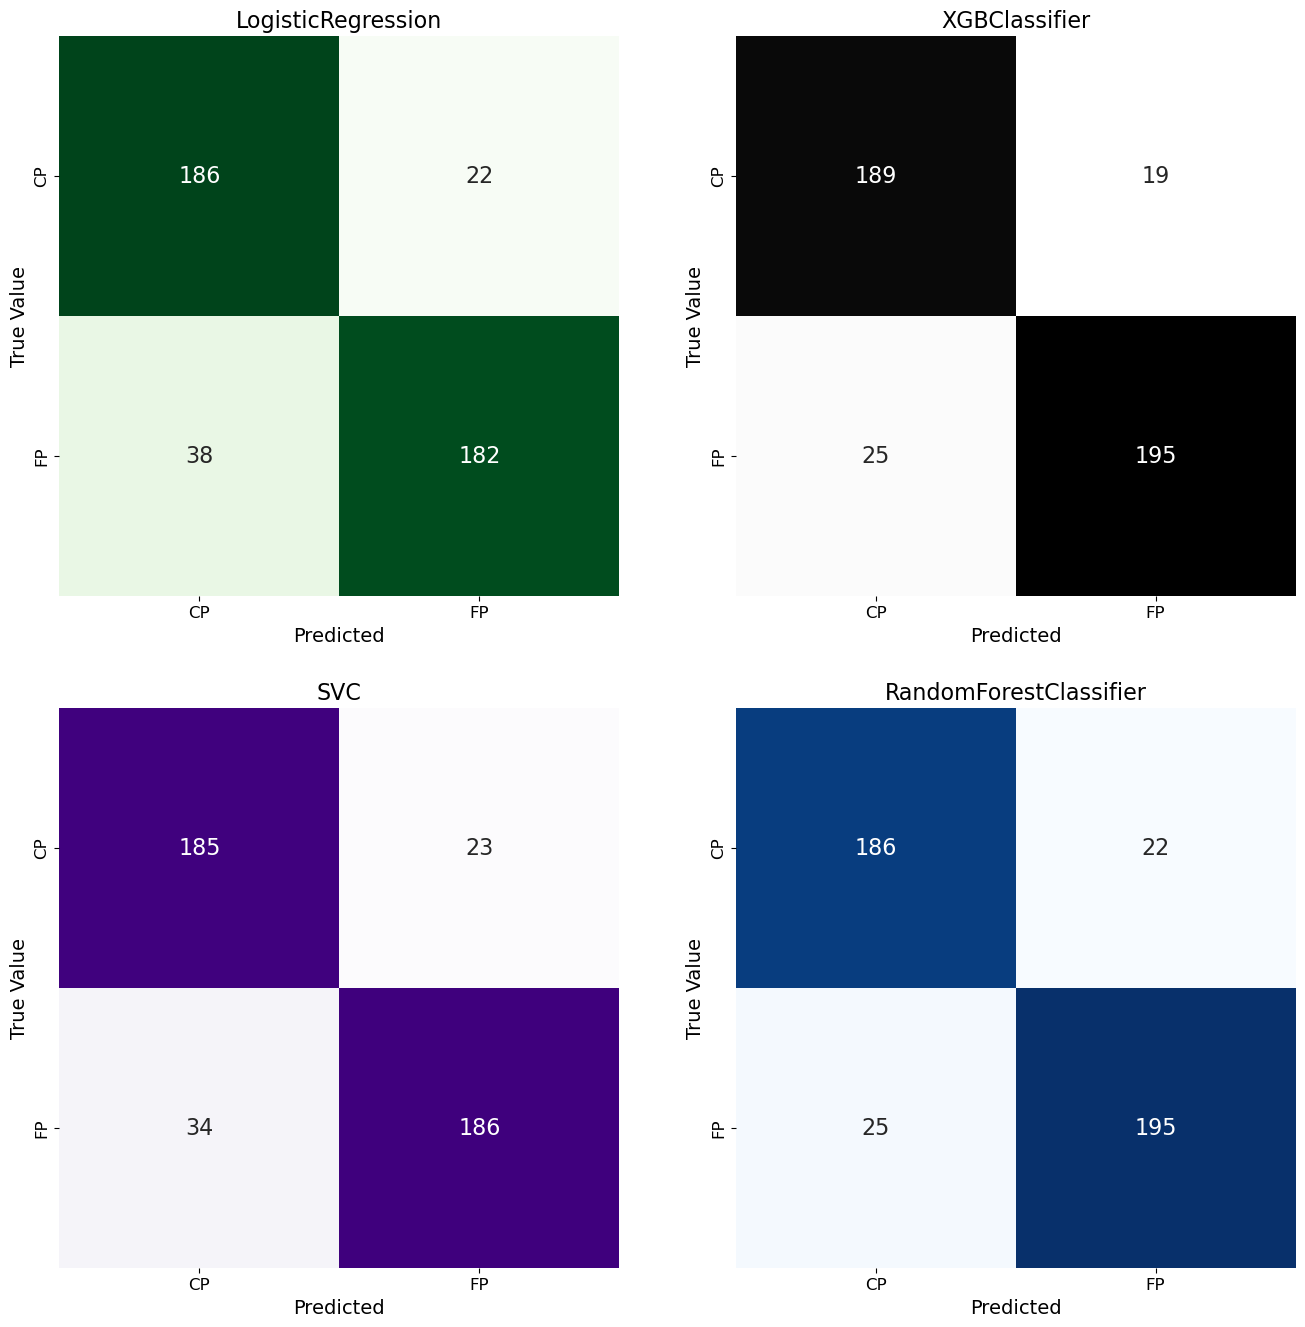

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))  # Two rows, two columns

# Organizing the plot display information in 2 x 2 arrays:
# [[(0, 0), (0, 1)],
#  [(1, 0), (1, 1)]]

plottitles = [['LogisticRegression', 'XGBClassifier'], 
              ['SVC', 'RandomForestClassifier']]

colors = [['Greens', 'Grays'], 
          ['Purples', 'Blues']] # seaborn color palettes

class_labels = ['CP', 'FP']

for i in range(0, 2):
    for j in range(0, 2):
        y_pred = predictions[plottitles[i][j]]
        confusion = confusion_matrix(y_true, y_pred)
        axis = sns.heatmap(data=confusion, 
                           cmap=colors[i][j], 
                           annot=True,
                           fmt='d', 
                           square=True,
                           ax=ax[i][j], 
                           xticklabels=class_labels, 
                           yticklabels=class_labels, 
                           cbar=False,
                           annot_kws={'size':16})
        
        ax[i][j].set_title(plottitles[i][j], fontsize=16)
        ax[i][j].set_xlabel("Predicted", fontsize=14)
        ax[i][j].set_ylabel("True Value", fontsize=14)
        axis.set_xticklabels(axis.get_xticklabels(), fontsize=12)
        axis.set_yticklabels(axis.get_yticklabels(), fontsize=12)
        
plt.show()

The Random Forest and XGBoost models both predicted the same about of false exoplanets (false negatives) on the testing set, however the XGBoost model
performed slightly better on ht

### Plotting Results of Model Predictions

#### *Pairplot coloured by the actual labels*
**Blue** points represent confirmed planets while **orange** points represent false positives.

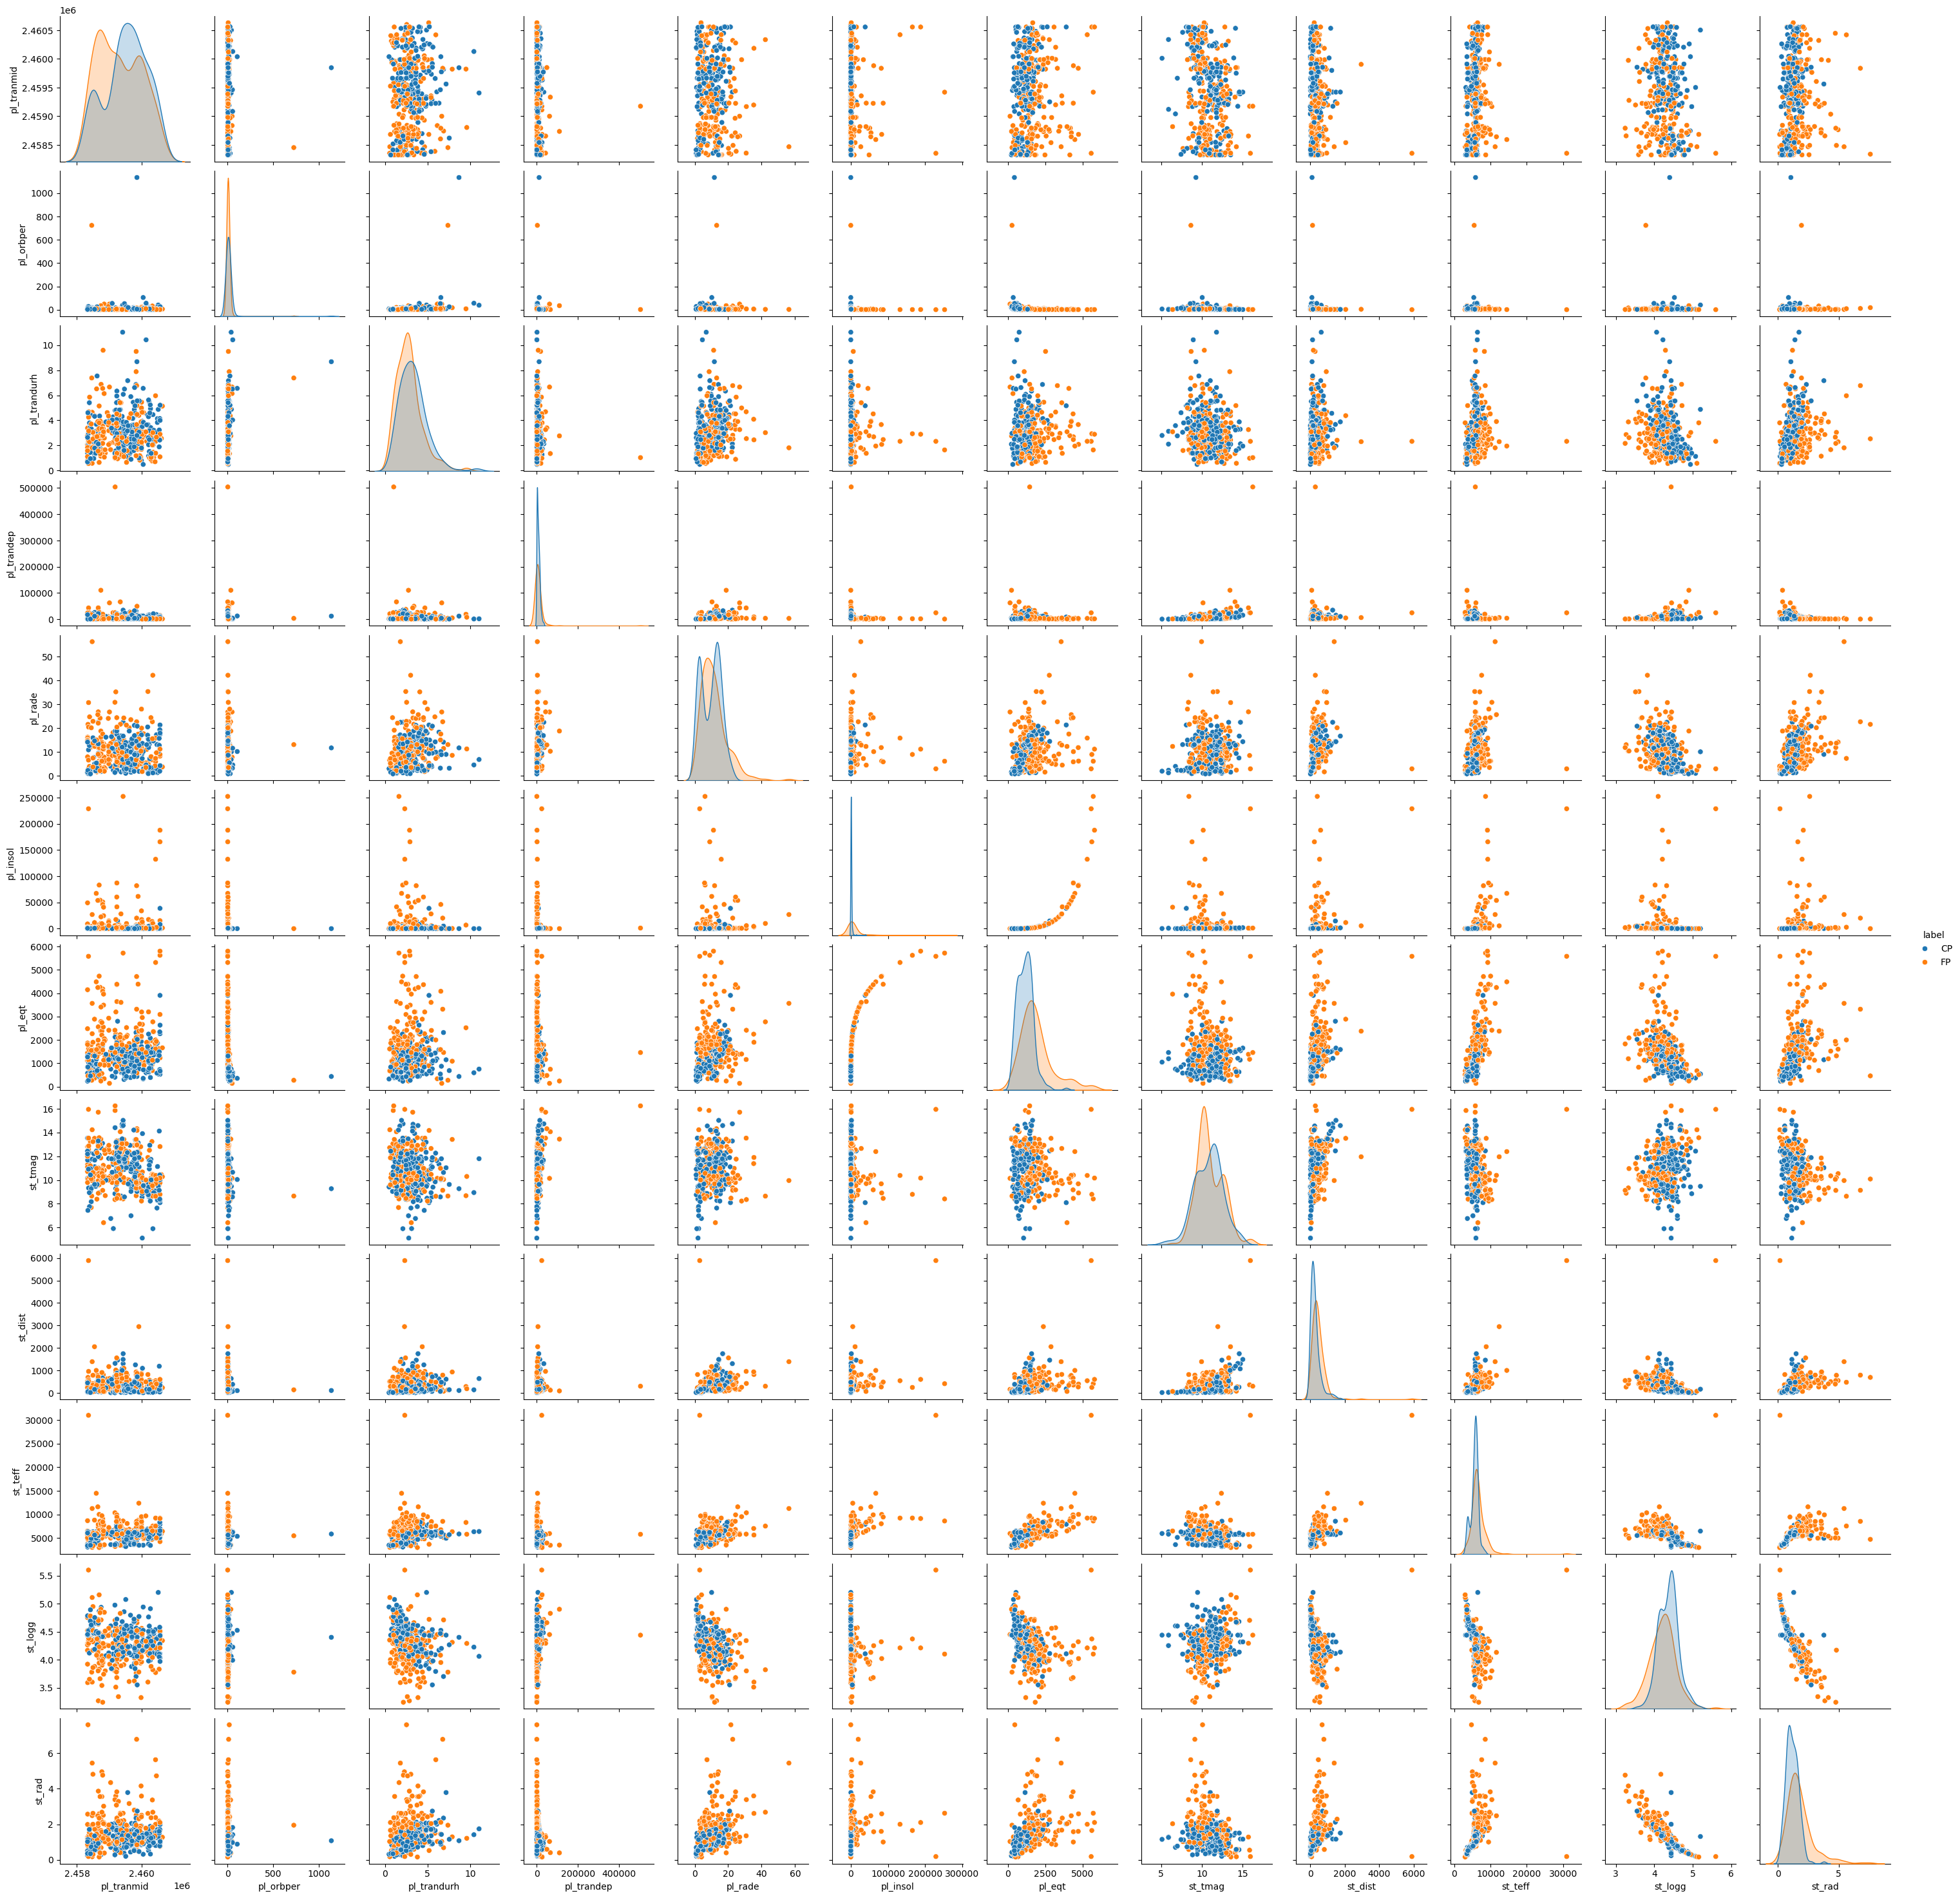

In [ ]:
X_plot = pd.DataFrame(X_test, columns=X.columns).drop(columns=err_cols)
X_plot = X_plot.drop(columns=['ra', 'dec', 'st_pmra', 'st_pmdec'])
X_plot['label'] = binarizer.inverse_transform(y_test)
sns.pairplot(data=X_plot, hue ='label', hue_order=['CP', 'FP'], diag_kind='kde')

#### *Pairplot coloured by the predicted labels*
The predictions are sourced from ``XGBoost`` which is the best performing model.
**Blue** points represent confirmed planets while **orange** points represent false positives.

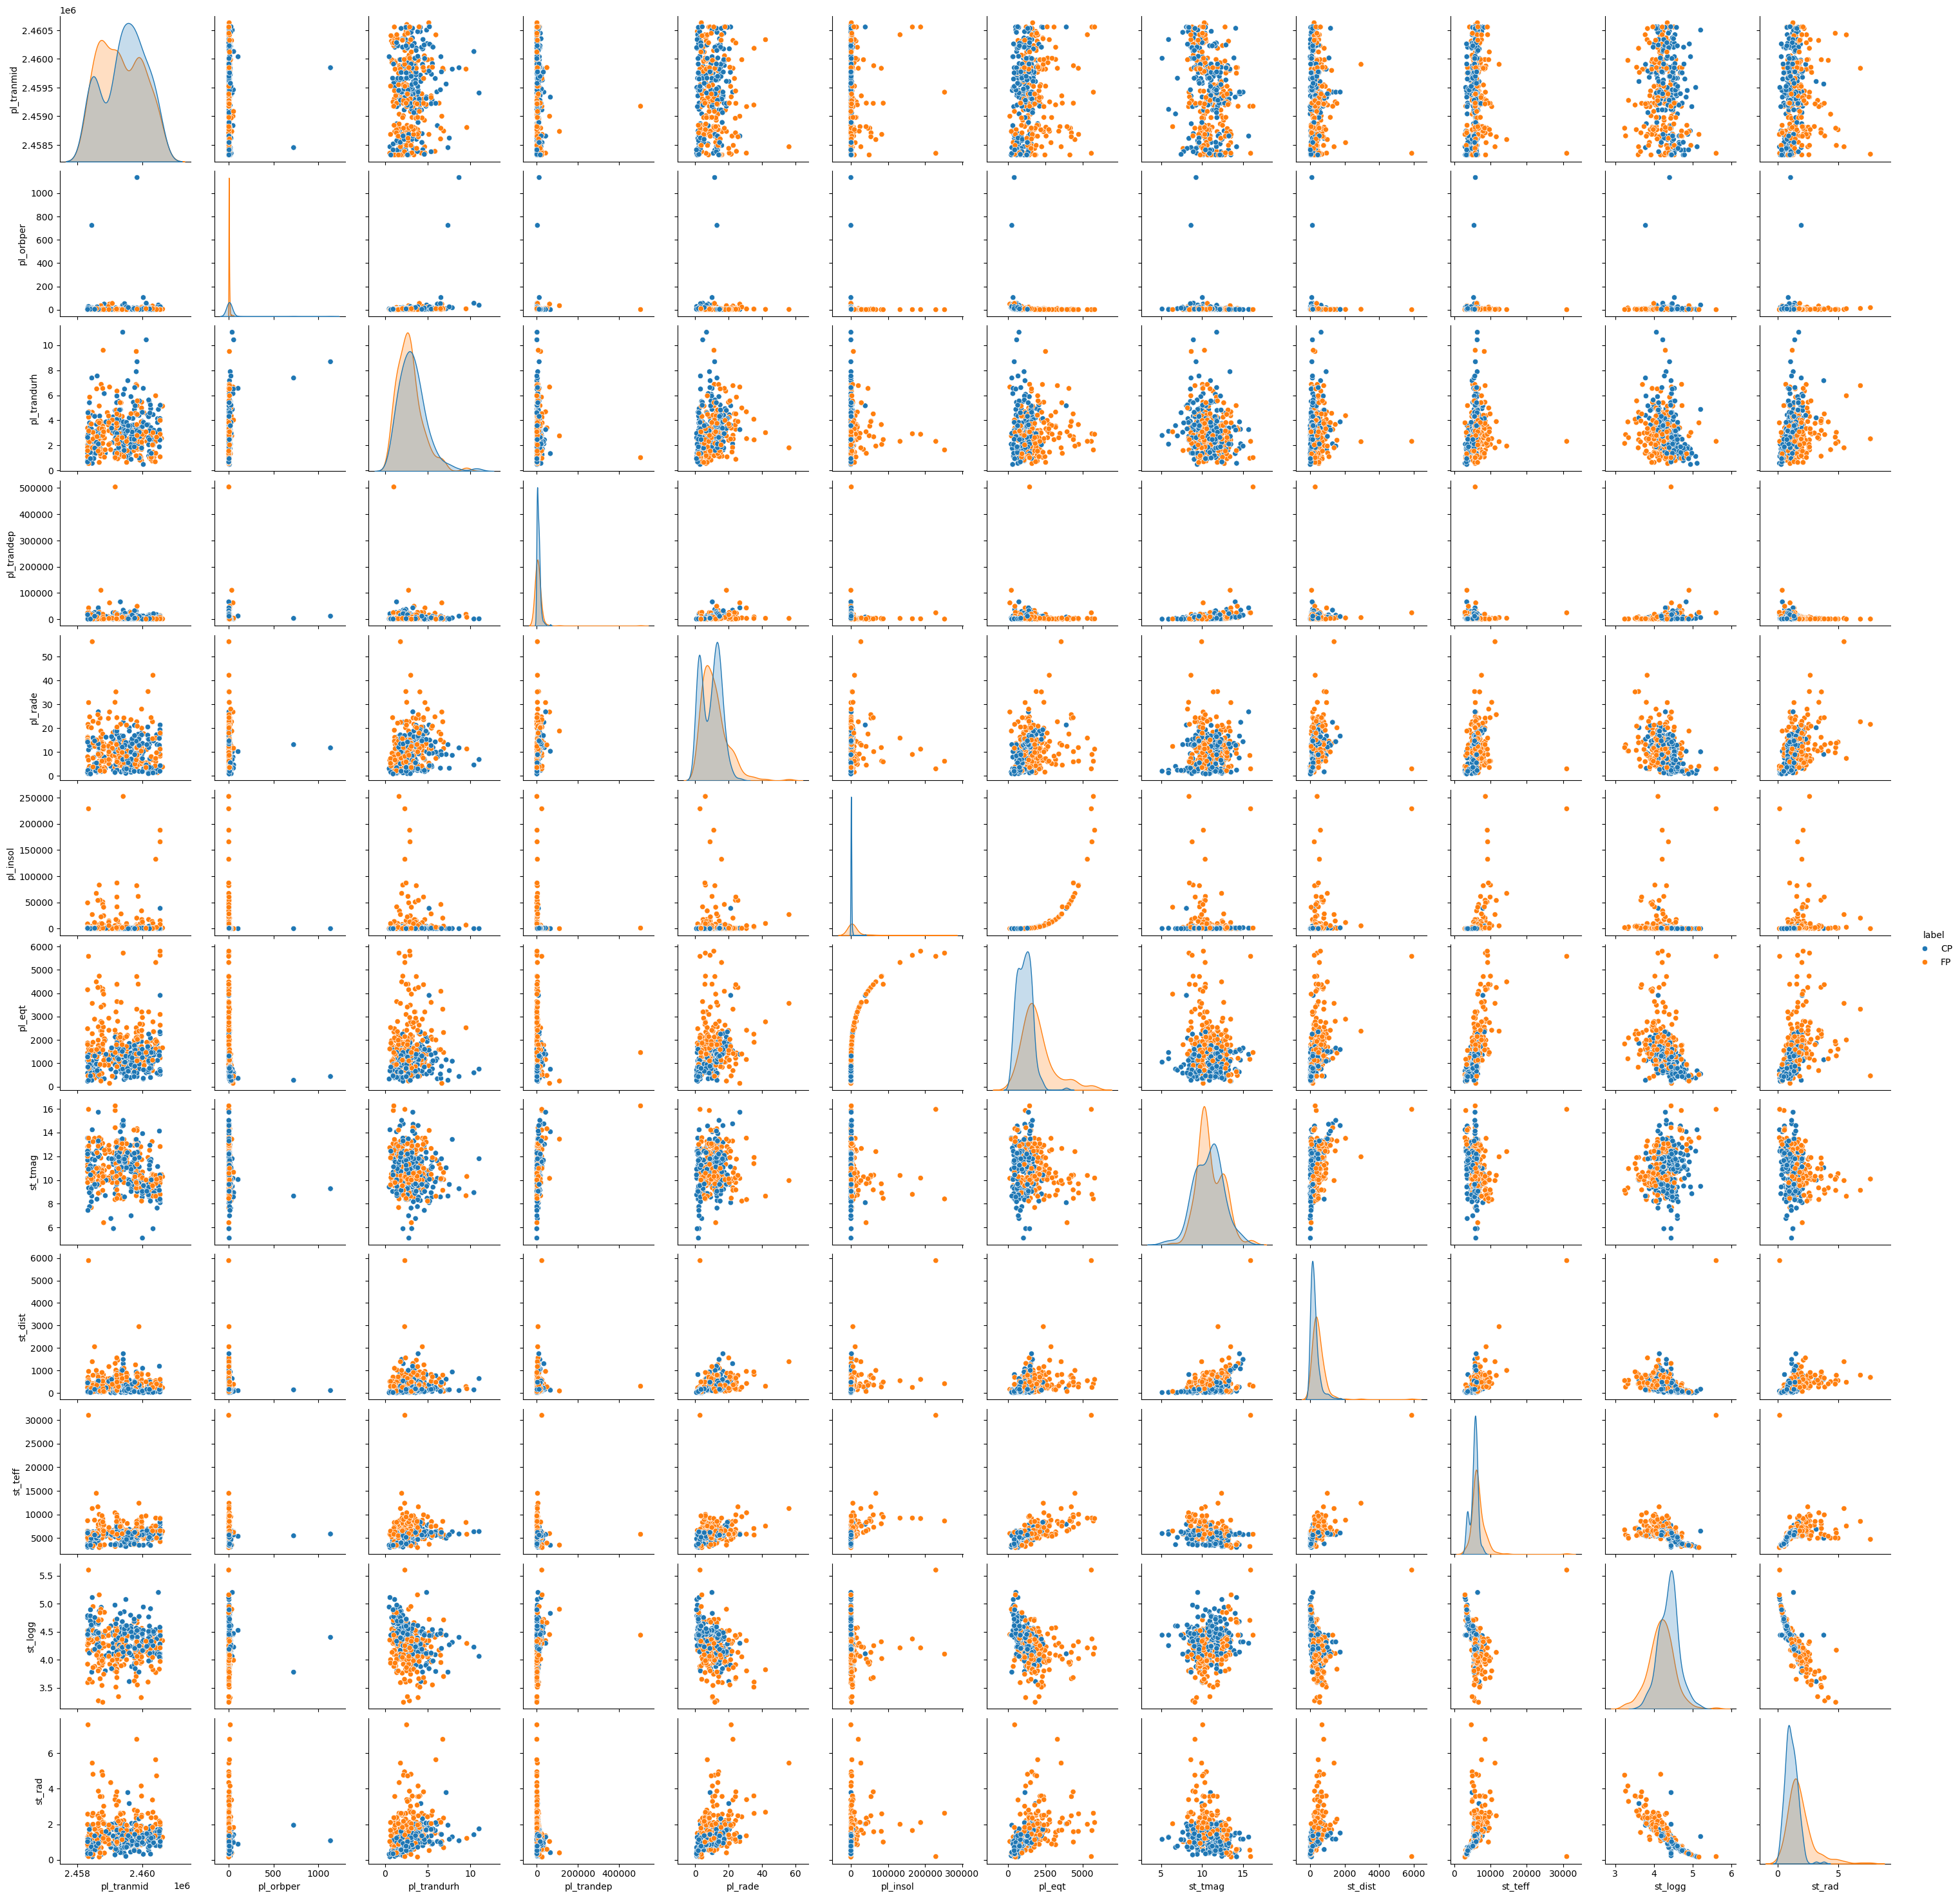

In [ ]:
y_pred_xgb = predictions['XGBClassifier']
X_plot['label'] = y_pred_xgb
sns.pairplot(data=X_plot, hue ='label', hue_order=['CP', 'FP'], diag_kind='kde')

### Performance Results of Original Models on Test Data

In [ ]:
baseline_scores = pd.DataFrame(columns=final_scores.columns)
for i in range(0, len(models)):
    pipeline = None
    if(i <=1):
        pipeline = Pipeline(steps=[
        ('preprocessing', preprocessing), # StandardScaler() + KNNImputer(n_neighbors=5)
        ('estimator', models[i])]) # use StandardScaler()
    else:
        pipeline = Pipeline(steps=[
            # NeutralImputer scales the data with RobustScaler, performs KNN imputatation
            # then calls inverse_transform() on the scaler. While it may be slightly excessive, 
            # the ensembles use 
            # This allows us to pass unscaled data to the final estimator within a pipeline
            ('preprocessing', neutral), 
            ('estimator', models[i])])
    
    pipeline.fit(X_train, y_train)
    scores_dict, _ = helpers.assess_model(pipeline, X_train, y_train, X_test, y_test)
    add_score_row(baseline_scores, scores_dict=scores_dict, model_name=model_names[i])
baseline_scores

Train Accuracy  Test Accuracy  Train Precision  \
LogisticRegression            0.790643       0.796729         0.831432   
SVC                           0.861404       0.845794         0.903509   
XGBClassifier                 1.000000       0.887850         1.000000   
RandomForestClassifier        1.000000       0.864486         1.000000   

                        Test Precision  Train Recall  Test Recall  
LogisticRegression            0.803653      0.744608     0.800000  
SVC                           0.873786      0.818388     0.818182  
XGBClassifier                 0.905660      1.000000     0.872727  
RandomForestClassifier        0.878505      1.000000     0.854545

### Final Model Performance Results

In [ ]:
final_scores

Train Accuracy  Test Accuracy  Train Precision  \
LogisticRegression            0.880702       0.859813         0.913309   
SVC                           0.907018       0.866822         0.938107   
XGBClassifier                 1.000000       0.897196         1.000000   
RandomForestClassifier        0.998830       0.890187         0.998865   

                        Test Precision  Train Recall  Test Recall  
LogisticRegression            0.892157      0.849035     0.827273  
SVC                           0.889952      0.877412     0.845455  
XGBClassifier                 0.911215      1.000000     0.886364  
RandomForestClassifier        0.898618      0.998865     0.886364

## Final Conclusion
Overall, ``XGBClassifier`` performed the best out of all the models, with the highest validation and testing scores for all the models. 
While the accuracy of the model is not high enough for it to replace proper reviewal by astronomers and researchers, its performance would
make it viable as a filtering tool to help astronomers within the *TESS Follow-Up Observation Program Working Group* identify candidates that
are likely to be exoplanets 